# Capstone Project - Sentiment Based Product Recommendation System

In [ ]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
#from wordcloud import WordCloud
from fractions import Fraction
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina'] #include it if you have high denisty retina display
import seaborn as sns #as it gives 2x plots with matplotlib and ipython notebook
import plotly.offline as py #to drew plotly
color = sns.color_palette()#graphs from a 
import plotly.offline as py#command line
py.init_notebook_mode(connected=True) #to create offine grapgs with notebook
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data/sample30.csv")

In [ ]:
data.head()

id            brand  ... reviews_username user_sentiment
0  AV13O1A8GV-KLJ3akUyj  Universal Music  ...           joshua       Positive
1  AV14LG0R-jtxr-f38QfS         Lundberg  ...        dorothy w       Positive
2  AV14LG0R-jtxr-f38QfS         Lundberg  ...        dorothy w       Positive
3  AV16khLE-jtxr-f38VFn              K-Y  ...          rebecca       Negative
4  AV16khLE-jtxr-f38VFn              K-Y  ...        walker557       Negative

[5 rows x 15 columns]

In [ ]:
#data overivew
print('rows: ', data.shape[0])
print('columns: ', data.shape[1])
print('\nfeatures: ', data.columns.to_list())
print('\nmissing vlues: ', data.isnull().values.sum())
print('\nUnique values: \n', data.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing vlues:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [ ]:
#see the data types of different columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [ ]:
data.isnull().sum()
  

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [ ]:
missingval = round(100*data.isnull().sum()/len(data.index),2)
missingval.loc[missingval > 0].sort_values(ascending=False)

reviews_userProvince    99.43
reviews_userCity        93.57
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_title            0.63
manufacturer             0.47
reviews_username         0.21
reviews_date             0.15
dtype: float64

reviews_userCity and reviews_userProvince are having 90% of their values as Null. Hence they can be dropped

In [ ]:
# Dropping review userCity and userProvince from data as most of the values are NULL

data2=data.drop(['reviews_userProvince','reviews_userCity'],axis=1)

In [ ]:
# Column reviews_doRecommend  is not in inline with data provided. With User rating 5 also do Recommend column is showing FALSE. 
# Hence dropping the column
# reviews_didPurchase column also 46.89 % is having NULL value. Hence dropping this column

data2.drop(['reviews_didPurchase','reviews_doRecommend'],axis=1,inplace=True)


In [ ]:
# Review Title and Review Text can be concatenated 

data2['reviewstext'] = data2[['reviews_title', 'reviews_text']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)
data2.head()


id  ...                                        reviewstext
0  AV13O1A8GV-KLJ3akUyj  ...  Just Awesome i love this album. it's very good...
1  AV14LG0R-jtxr-f38QfS  ...  Good Good flavor. This review was collected as...
2  AV14LG0R-jtxr-f38QfS  ...                                  Good Good flavor.
3  AV16khLE-jtxr-f38VFn  ...  Disappointed I read through the reviews on her...
4  AV16khLE-jtxr-f38VFn  ...  Irritation My husband bought this gel for us. ...

[5 rows x 12 columns]

In [ ]:
# As we have combined reviews_text and reviews_title in one column, we can drop them

data2.drop(['reviews_text', 'reviews_title'], axis = 1,inplace=True)

In [ ]:
missingval = round(100*data2.isnull().sum()/len(data2.index),2)
missingval.loc[missingval > 0].sort_values(ascending=False)

manufacturer        0.47
reviews_username    0.21
reviews_date        0.15
dtype: float64

In [ ]:
# For missing manufacturer names we can fill brand name

data2.loc[data2.manufacturer.isnull(),'manufacturer'] = data2.brand

In [ ]:
missingval = round(100*data2.isnull().sum()/len(data2.index),2)
missingval.loc[missingval > 0].sort_values(ascending=False)

reviews_username    0.21
reviews_date        0.15
dtype: float64

In [ ]:
# We having 63 usernames having null values. We can drop these rows from data as we cannot find user similarity based on this data

data2 = data2.loc[data2['reviews_username'].notnull(),:]

In [ ]:
# Drop all rows having NULL review time

data2 = data2.loc[data2['reviews_date'].notnull(),:]

In [ ]:
missingval = round(100*data2.isnull().sum()/len(data2.index),2)
missingval.loc[missingval > 0].sort_values(ascending=False)

Series([], dtype: float64)

Now data is cleaned 

In [ ]:
# We can derive review year from review date

data2['reviews_year']=data2.reviews_date.str[:4]
# pd.DatetimeIndex(data2['reviews_date']).year

# data2.reviews_date.str[:4].head()

In [ ]:
data2['reviews_year'].value_counts()

2014    8373
2015    6455
2016    4956
2012    4295
2017    3149
2013    1322
2009     480
2011     448
2010     376
2008      22
2007      10
 hoo       8
2018       3
Name: reviews_year, dtype: int64

8 rows are having invalid year. Drop them

In [ ]:
data2 = data2[data2.reviews_year != ' hoo']

In [ ]:
data2.head()

id  ... reviews_year
0  AV13O1A8GV-KLJ3akUyj  ...         2012
1  AV14LG0R-jtxr-f38QfS  ...         2017
2  AV14LG0R-jtxr-f38QfS  ...         2017
3  AV16khLE-jtxr-f38VFn  ...         2016
4  AV16khLE-jtxr-f38VFn  ...         2016

[5 rows x 11 columns]

In [ ]:
# Now we can drop reviews_date column

# data2.drop(['reviews_date'],axis=1,inplace=True)

In [ ]:
##########################################
## Classify ratings as good
##########################################

good_rate = len(data2[data2['reviews_rating'] >= 3])
bad_rate = len(data2[data2['reviews_rating'] < 3])

# Printing rating and their total numbers
print ('Good ratings : {} reviews for products'.format(good_rate))
print ('Bad ratings : {} reviews for products'.format(bad_rate))

Good ratings : 28106 reviews for products
Bad ratings : 1783 reviews for products


In [ ]:
# Add new column rating class

data2['rating_class'] = data2['reviews_rating'].apply(lambda x: 'bad' if x < 3 else'good')
data2.head()

id            brand  ... reviews_year rating_class
0  AV13O1A8GV-KLJ3akUyj  Universal Music  ...         2012         good
1  AV14LG0R-jtxr-f38QfS         Lundberg  ...         2017         good
2  AV14LG0R-jtxr-f38QfS         Lundberg  ...         2017         good
3  AV16khLE-jtxr-f38VFn              K-Y  ...         2016          bad
4  AV16khLE-jtxr-f38VFn              K-Y  ...         2016          bad

[5 rows x 12 columns]

In [ ]:
data2[data2.duplicated(['reviews_username','reviews_date','id'],keep= False)]

id          brand  ... reviews_year rating_class
1      AV14LG0R-jtxr-f38QfS       Lundberg  ...         2017         good
2      AV14LG0R-jtxr-f38QfS       Lundberg  ...         2017         good
10     AV16khLE-jtxr-f38VFn            K-Y  ...         2016          bad
12     AV16khLE-jtxr-f38VFn            K-Y  ...         2016          bad
67     AV1l8zRZvKc47QAVhnAv           Olay  ...         2016         good
...                     ...            ...  ...          ...          ...
28353  AVpfRTh1ilAPnD_xYic2         Disney  ...         2014         good
28355  AVpfRTh1ilAPnD_xYic2         Disney  ...         2014         good
28356  AVpfRTh1ilAPnD_xYic2         Disney  ...         2014         good
29065  AVpfW8y_LJeJML437ySW  L'oreal Paris  ...         2017         good
29436  AVpfW8y_LJeJML437ySW  L'oreal Paris  ...         2017         good

[306 rows x 12 columns]

In [ ]:
data2.shape

(29889, 12)

In [ ]:

data2 = data2.drop_duplicates(['reviews_username','reviews_date','id'], keep = 'first')

In [ ]:
data2.shape

(29734, 12)

In [ ]:
##########################################
## DESCRIPTIVE STATISTICS
##########################################

print ("================================================")

### Total reviews
total = len(data2)
print ("Number of reviews: ",total)
print ()

### How many unique reviewers?
print ("Number of unique reviewers: ",len(data2.reviews_username.unique()))
reviews_username_prop = float(len(data2.reviews_username.unique())/total)
print ("prop of unique reviewers: ",round(reviews_username_prop,3))
print ()

### How many unique products?
print ("Number of unique products: ", len(data2.name.unique()))
product_prop = float(len(data2.name.unique())/total)
print ("Prop of unique products: ",round(product_prop,3))
print ()

### Average star score
print ("Average rating score: ",round(data2.reviews_rating.mean(),3))

# ### Average helpful ratio
# print ("Average helpfull ratio score: ",round(product_reviews_hp4.help_prop.mean(),3))


print ("================================================")

Number of reviews:  29734

Number of unique reviewers:  24869
prop of unique reviewers:  0.836

Number of unique products:  268
Prop of unique products:  0.009

Average rating score:  4.484


How are the ratings distributed

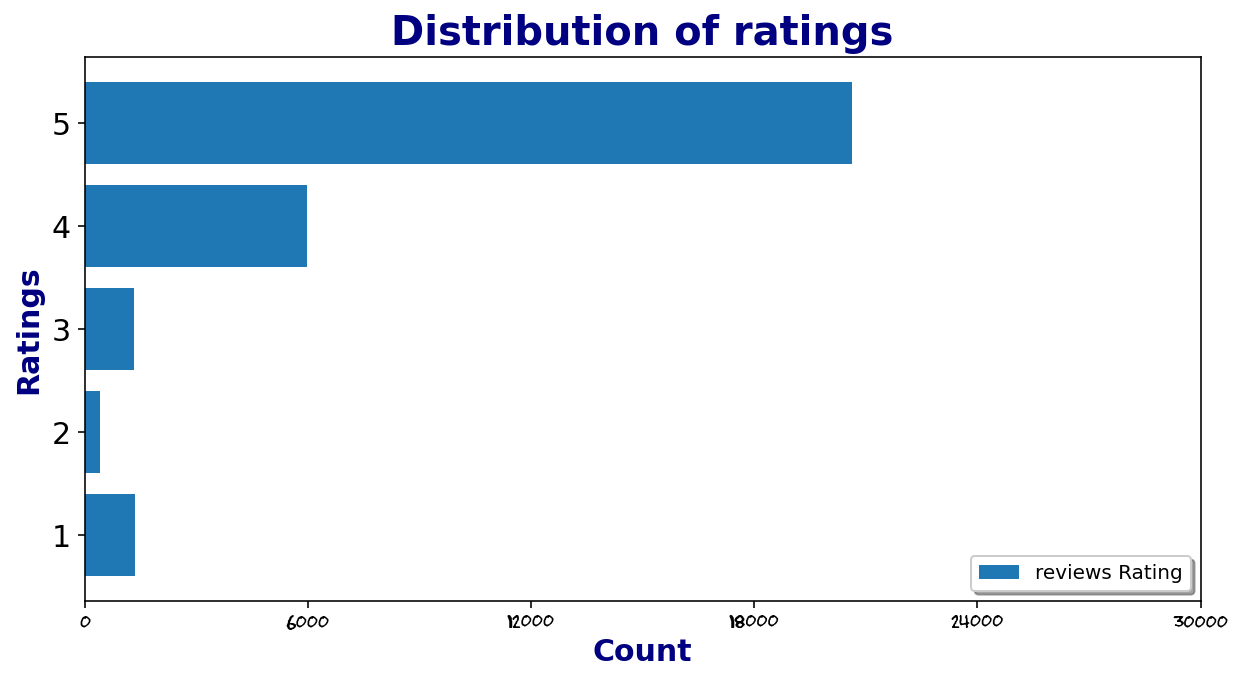

In [ ]:
#plot ratings frequency
plt.figure(figsize=[10,5]) #[width, height]
x = list(data2['reviews_rating'].value_counts().index)
y = list(data2['reviews_rating'].value_counts())
plt.barh(x, y)

ticks_x = np.linspace(0, 30000, 6) # (start, end, no of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks(size=15)

plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='navy')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.legend(['reviews Rating'], shadow=True, loc=4)
#Loc =1 topright, loc=2 topleft, loc=3 bottomleft, loc=4 bottom right, loc=9 topmiddle
#plt.grid() #add grid lines

In [ ]:
##########################################
## DISTRIBUTION OF RATING SCORE
########################################## 

class_counts = data2.groupby('reviews_rating').size()
class_counts

reviews_rating
1     1368
2      411
3     1331
4     5988
5    20636
dtype: int64

In [ ]:
##########################################
# Customer totals for each rating class
##########################################
data2['rating_class'].value_counts()

good    27955
bad      1779
Name: rating_class, dtype: int64

In [ ]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(data2['reviews_username'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(data2['name'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(data2)/len(data2['reviews_username'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(data2)/len(data2['name'].unique()))))



Number of unique customers : 24869

Number of unique products : 268

Review per customer: 1.1956250753950701

Review per product: 110.94776119402985


### Data Preprocessing

In [ ]:
!pip install contractions

     |████████████████████████████████| 266kB 11.3MB/s 
     |████████████████████████████████| 327kB 18.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84332 sha256=a7e04f065b1548f491c839685fa587ea16d7328be508560b0d5a27c08d7a9cef
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [ ]:
import contractions
from contractions import contractions_dict

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import unicodedata
import contractions
from contractions import contractions_dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# calculate raw tokens in order to measure of cleaned tokens

from nltk.tokenize import word_tokenize
raw_tokens=len([w for t in (data2["reviewstext"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))


Number of raw tokens: 1250897


In [ ]:
import re, string, unicodedata
import nltk
import contractions
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text



# Define function to expand contractions
def expand_contractions(text):
#     contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),flags=re.IGNORECASE|re.DOTALL)
#     def expand_match(contraction):
#         match = contraction.group(0)
#         first_char = match[0]
#         expanded_contraction = contractions_dict.get(match)\
#                         if contractions_dict.get(match)\
#                         else contractions_dict.get(match.lower())
#         expanded_contraction = first_char+expanded_contraction[1:]
#         return expanded_contraction
    
#     expanded_text = contractions_pattern.sub(expand_match, text)
#     expanded_text = re.sub("'", "", expanded_text)
    return contractions.fix(text)


# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas


In [ ]:
def normalize_and_lemmaize(input):
    sample = denoise_text(input)
#     sample = expand_contractions(sample)
    
    sample = contractions.fix(sample)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [ ]:
data2['clean_reviewstext'] = data2['reviewstext'].map(lambda text: normalize_and_lemmaize(text))


In [ ]:
data2.head()

id  ...                                  clean_reviewstext
0  AV13O1A8GV-KLJ3akUyj  ...  awesome love album good hip hop side current p...
1  AV14LG0R-jtxr-f38QfS  ...     good good flavor review collect part promotion
3  AV16khLE-jtxr-f38VFn  ...  disappoint read review look buy one couple lub...
4  AV16khLE-jtxr-f38VFn  ...  irritation husband buy gel us gel cause irrita...
5  AV16khLE-jtxr-f38VFn  ...  not worth boyfriend buy spice things bedroom h...

[5 rows x 13 columns]

In [ ]:
# Let's put aside number of raw tokens in order to measure of cleaned tokens
from nltk.tokenize import word_tokenize
clean_tokens=len([w for t in (data2["clean_reviewstext"].apply(word_tokenize)) for w in t])
#clean_tokens=len((product_reviews_hp4["clean_text"]))
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 585175

Percentage of removed tokens: 0.53


### EDA 

In [ ]:
clean_data = data2

In [ ]:
import pandas_profiling as pp

In [ ]:
clean_data.describe()

reviews_rating
count    29734.000000
mean         4.483588
std          0.987077
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000

Text(0, 0.5, 'Number of Reviews')

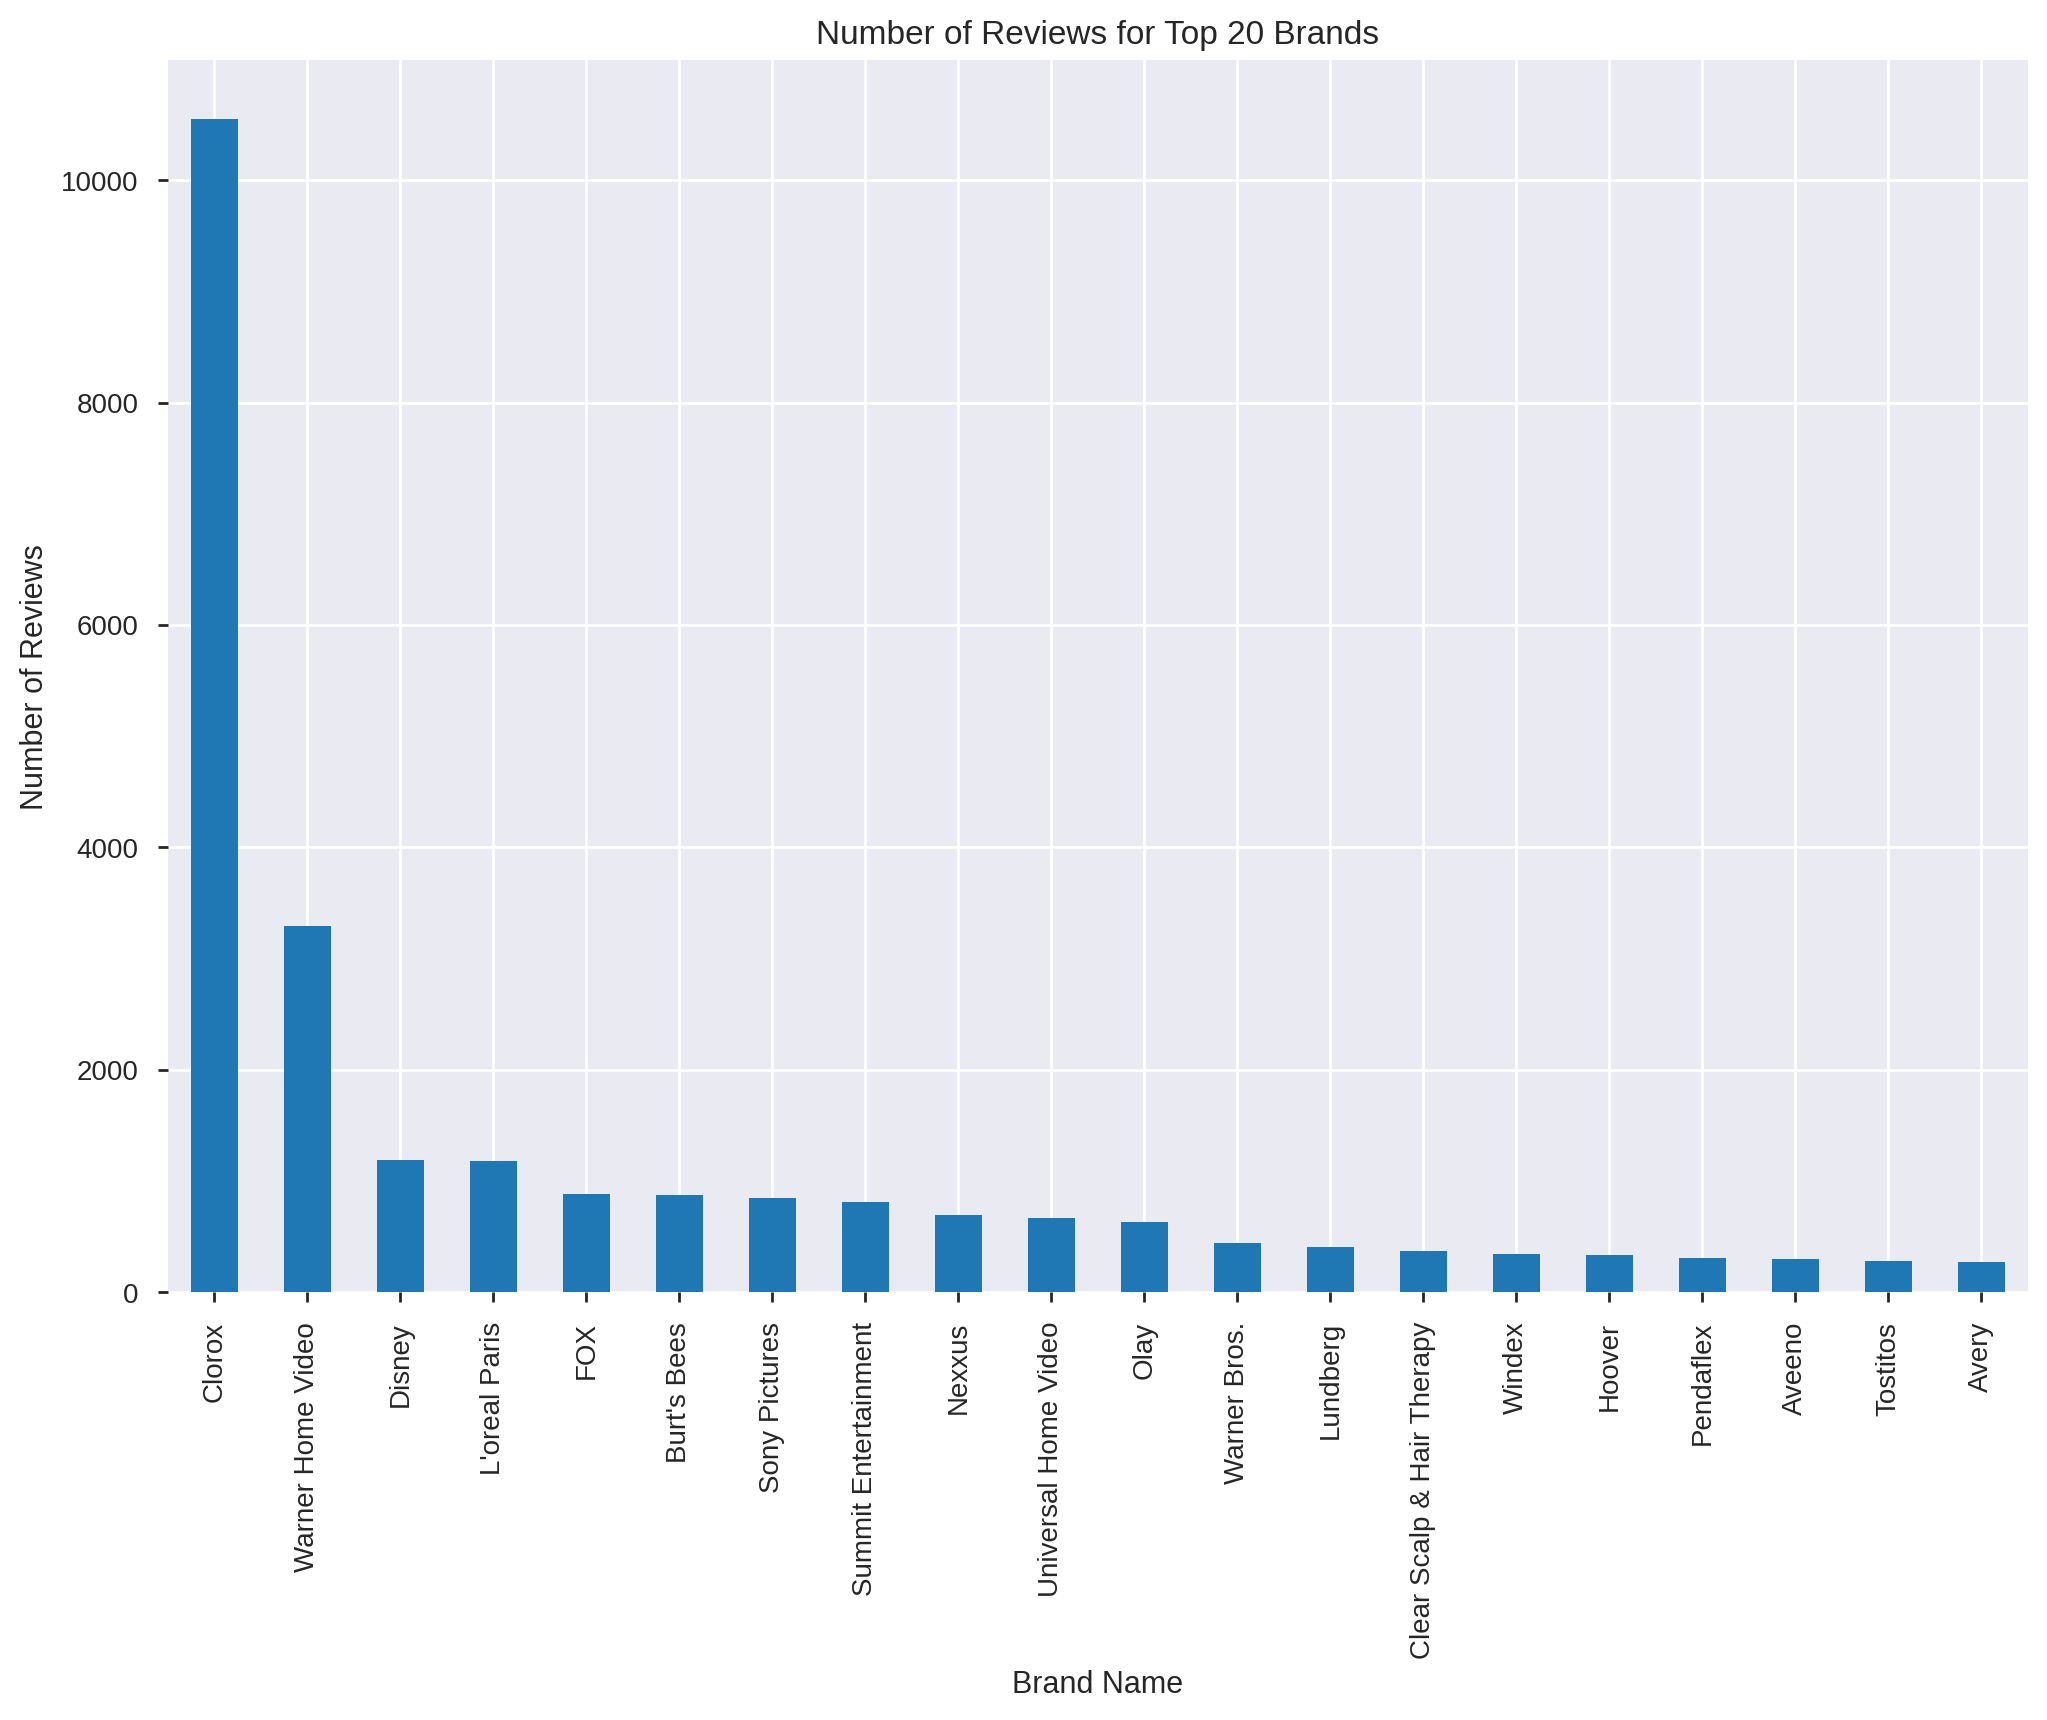

In [ ]:
##########################################
## PLOT NUMBER OF REVIEWS FOR TOP 20 BRANDS  
##########################################

brands = clean_data["brand"].value_counts()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

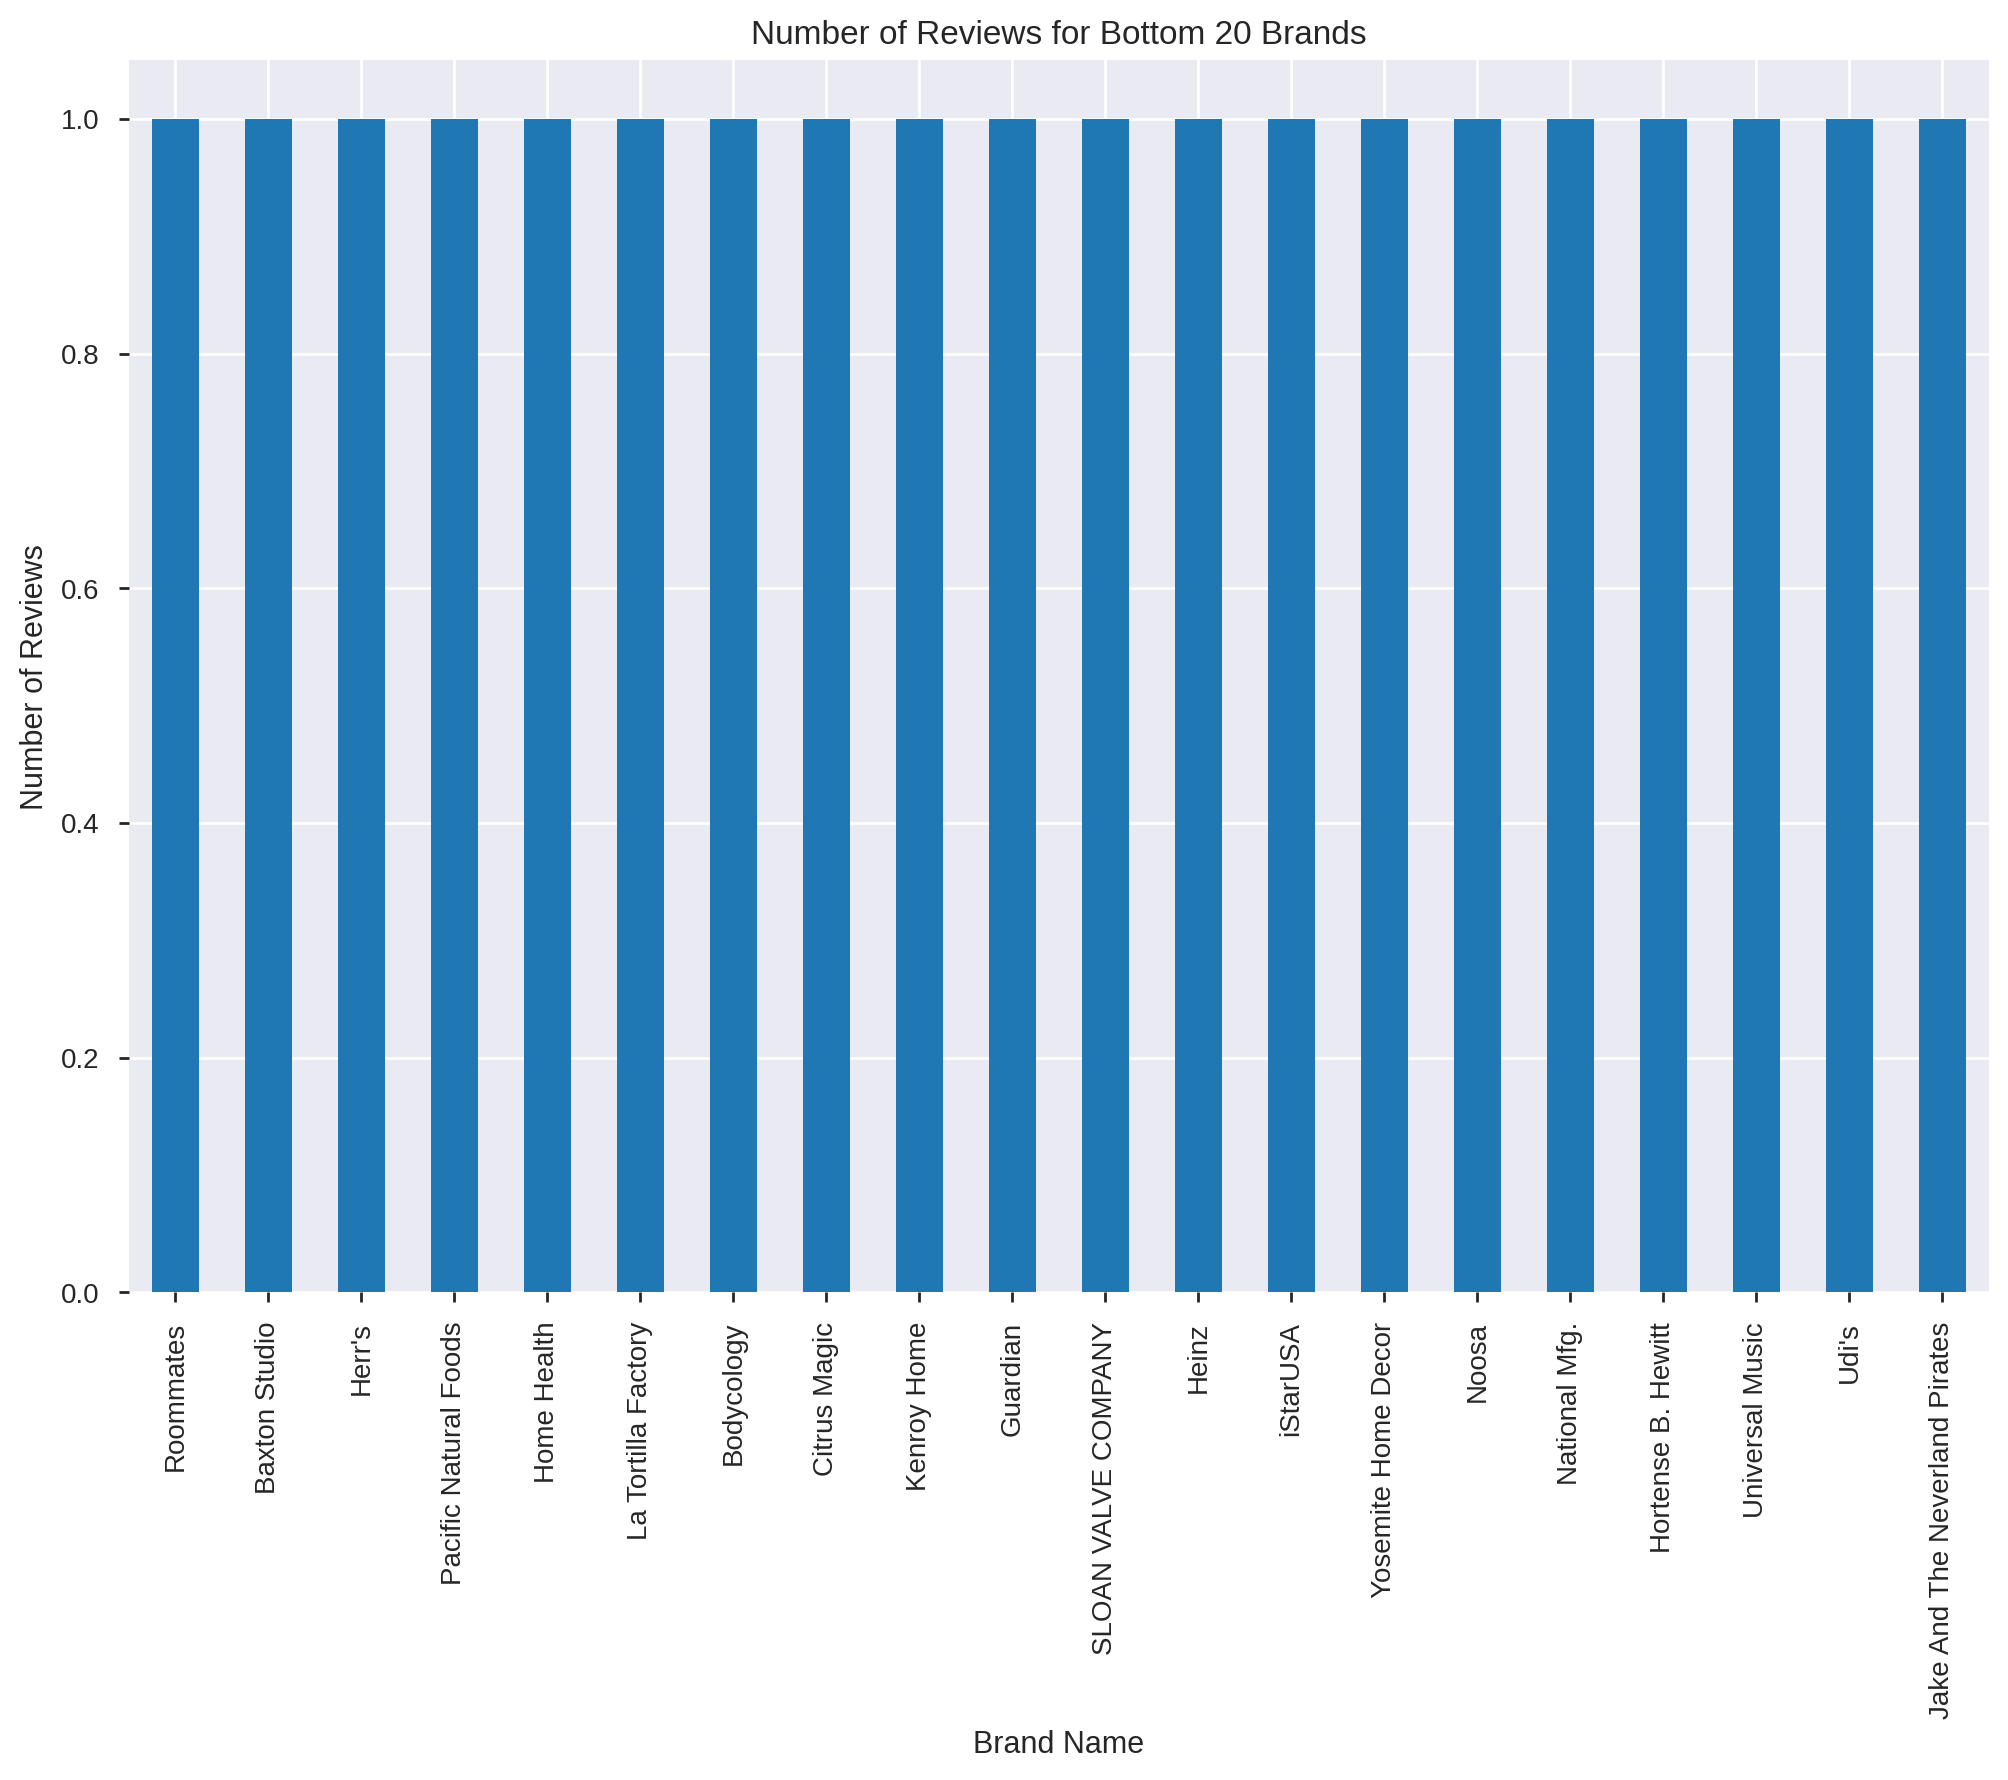

In [ ]:
##########################################
## PLOT NUMBER OF REVIEWS FOR BOTTOM 20 BRANDS  
##########################################

brands = clean_data["brand"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[-20:].plot(kind='bar')
plt.title("Number of Reviews for Bottom 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

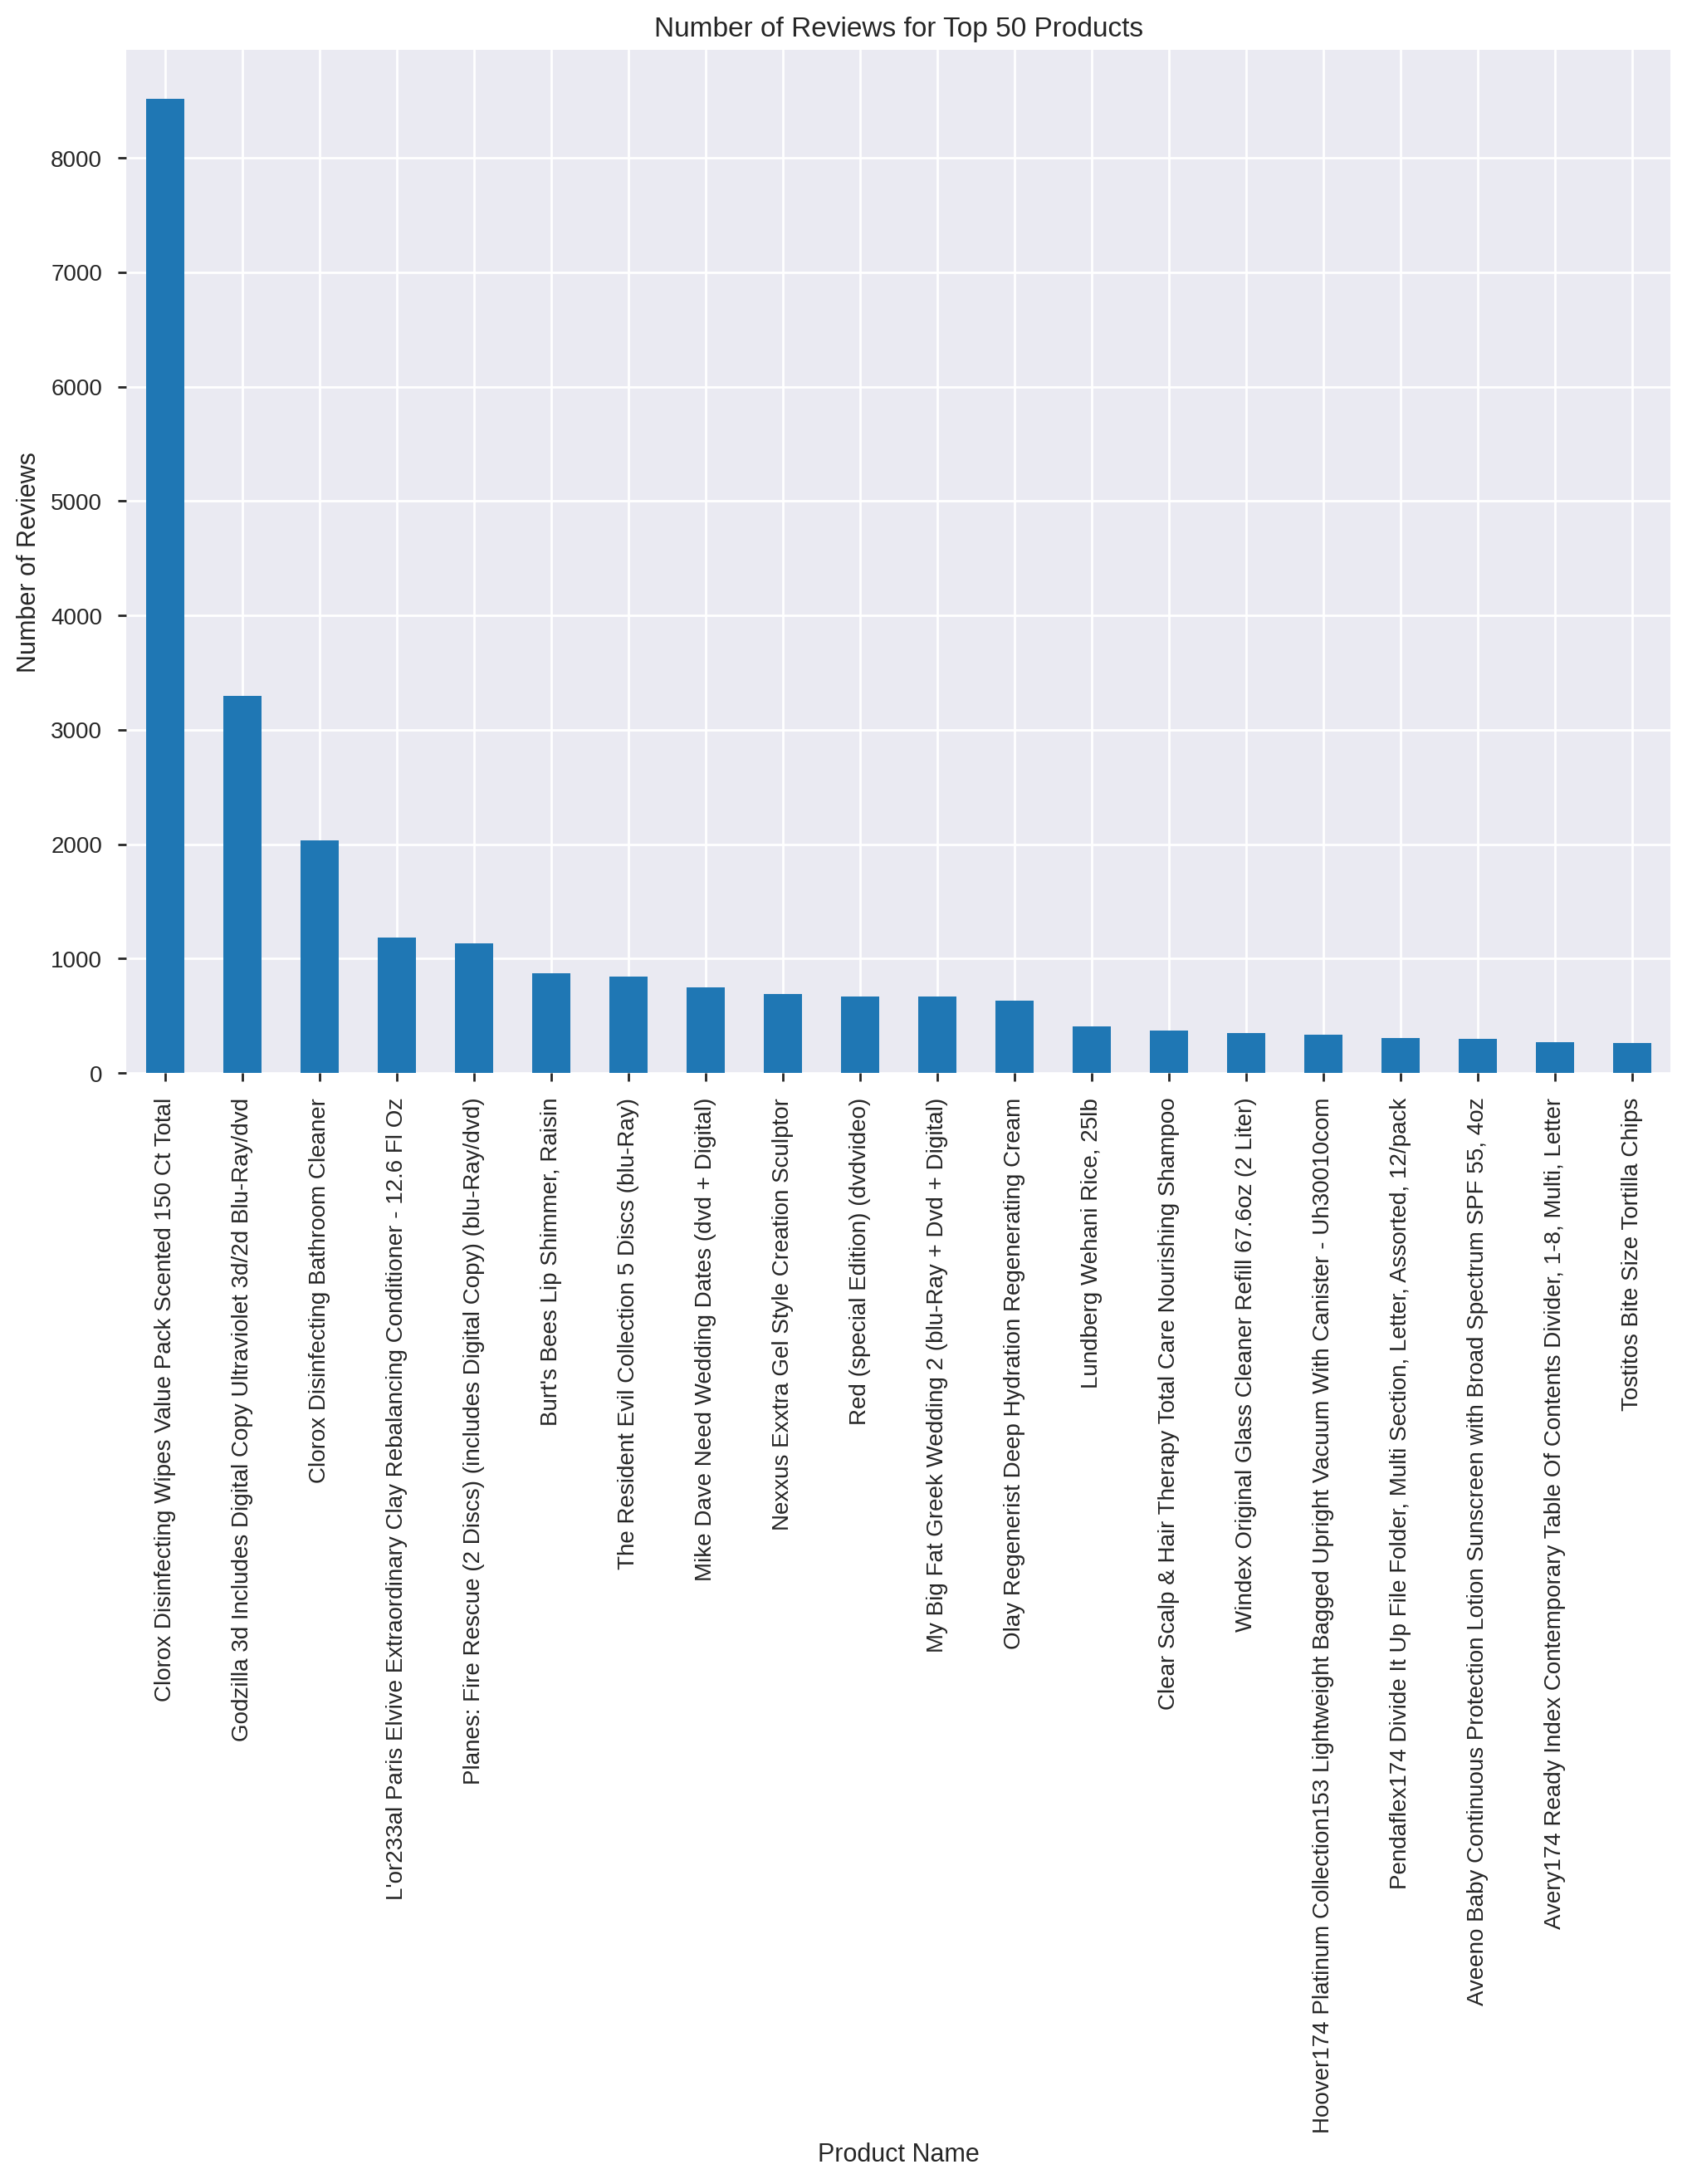

In [ ]:
##########################################
## PLOT NUMBER OF REVIEWS FOR TOP 20 PRODUCTS  
##########################################

products = clean_data["name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")
plt.xlabel('Product Name')
plt.ylabel('Number of Reviews')

In [ ]:
from nltk.tokenize import RegexpTokenizer
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

ListWords = []
for m in clean_data['clean_reviewstext']:
    n = RegExpTokenizer(str(m))
    ListWords.append(n)
print(ListWords[10])


['waste', 'money', 'purchase', 'think', 'would', 'sort', 'warm', 'effect', 'original', 'not', 'waste', 'money']


In [ ]:
#All Words
from nltk import FreqDist
def Bag_Of_Words(ListWords):
    all_words = []
    for m in ListWords:
        for w in m:
            all_words.append(w.lower())
    all_words1 = FreqDist(all_words)
    return all_words1

Total Words !!! 17619


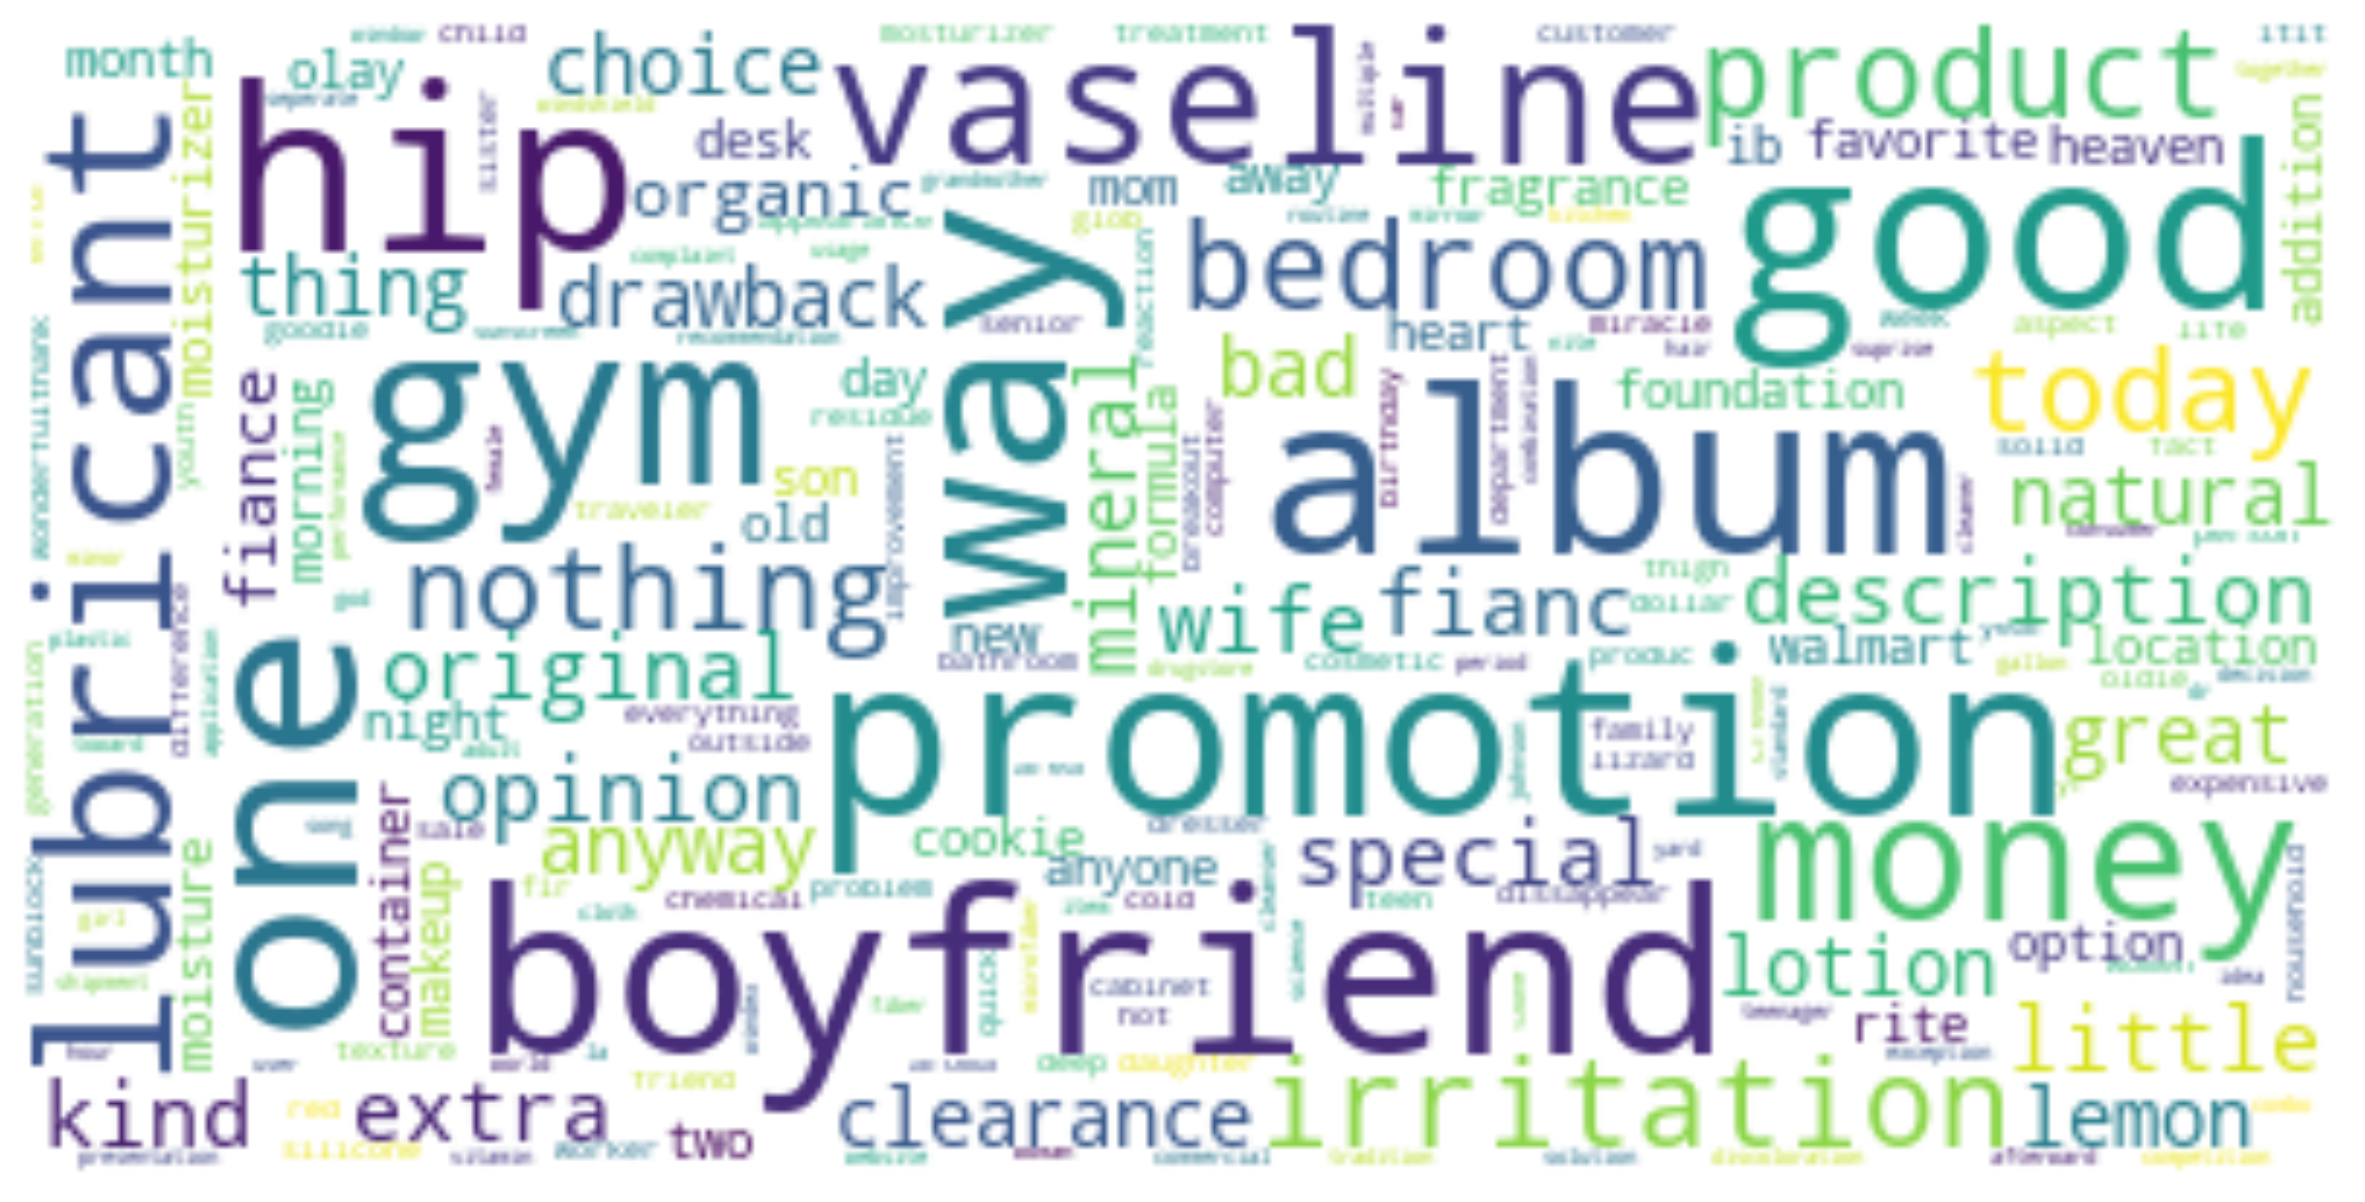

In [ ]:
import matplotlib as mpl
from wordcloud import WordCloud
all_words4 = Bag_Of_Words(ListWords)
ax = plt.figure(figsize=(15,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',max_font_size=40).generate(' '.join(all_words4.keys()))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Total Words !!!",len(all_words4))


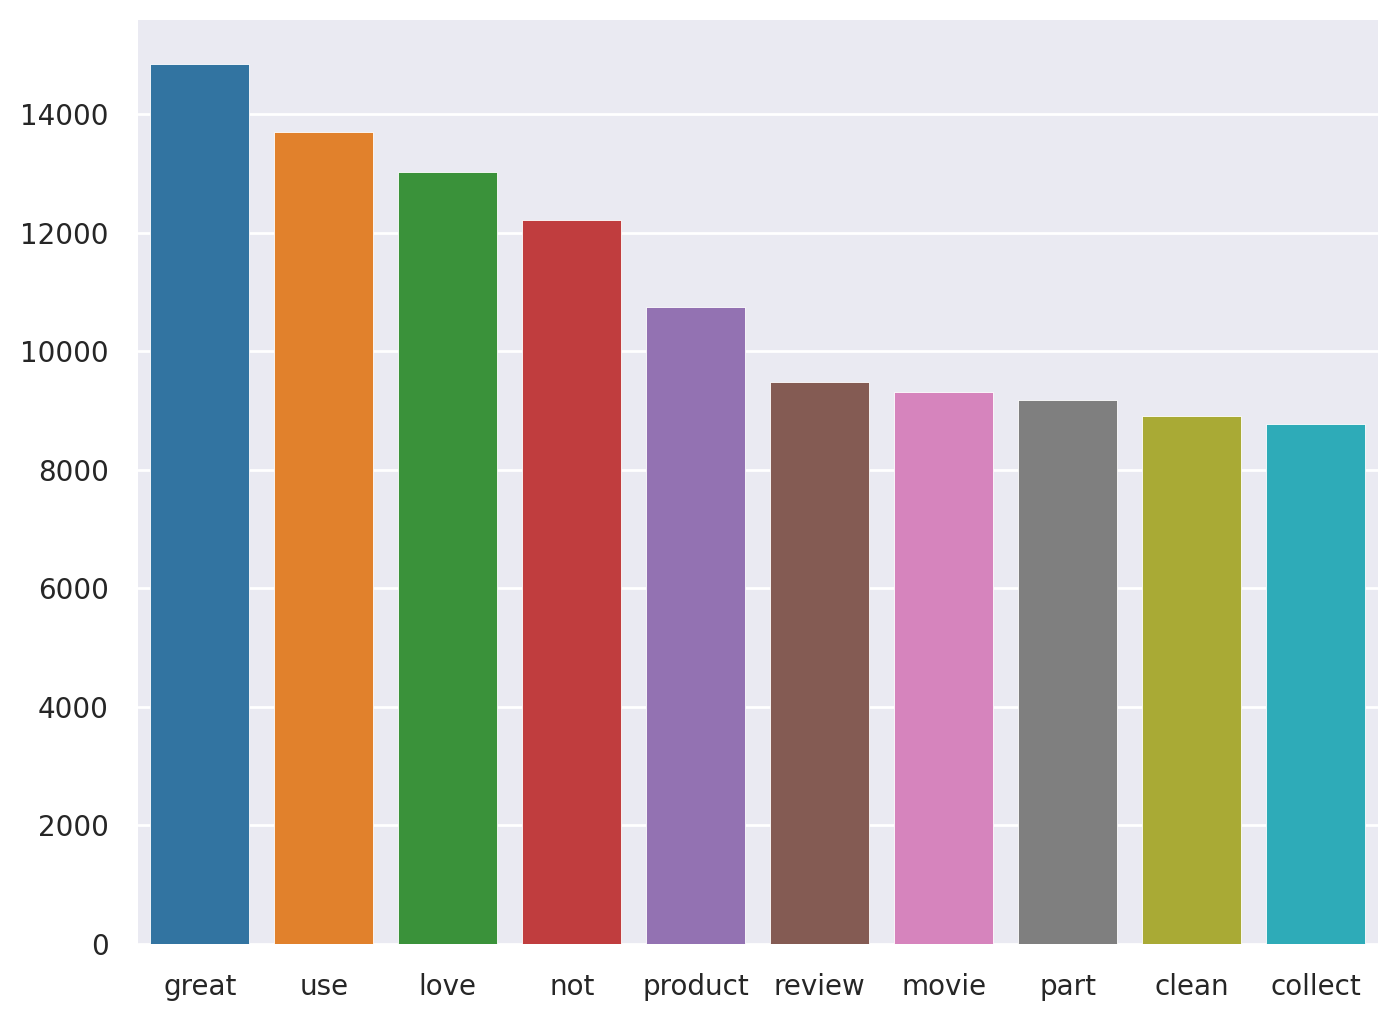

In [ ]:
plt.figure(figsize = (8,6))
import seaborn as sns
from sklearn.manifold import TSNE
all_words4 = Bag_Of_Words(ListWords)
count = []
Words  = []
for w in all_words4.most_common(10):
    count.append(w[1])
    Words.append(w[0])
sns.set_style("darkgrid")
sns.barplot(Words,count)

In [ ]:
# Get all products with rating_class = bad

data_bad = clean_data[clean_data['rating_class'] == 'bad']

# data2[data2['reviews_rating'] < 3]

In [ ]:
from nltk.tokenize import RegexpTokenizer
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

ListWords1 = []
for m in data_bad['clean_reviewstext']:
    n = RegExpTokenizer(str(m))
    ListWords1.append(n)
print(ListWords1[1])

['irritation', 'husband', 'buy', 'gel', 'us', 'gel', 'cause', 'irritation', 'felt', 'like', 'burn', 'skin', 'would', 'not', 'recommend', 'gel']


In [ ]:
#All Words
from nltk import FreqDist
def Bag_Of_Words(ListWords1):
    all_words1 = []
    for m in ListWords1:
        for w in m:
            all_words1.append(w.lower())
    all_words2 = FreqDist(all_words1)
    return all_words2

Combien de Mots !!! 4403


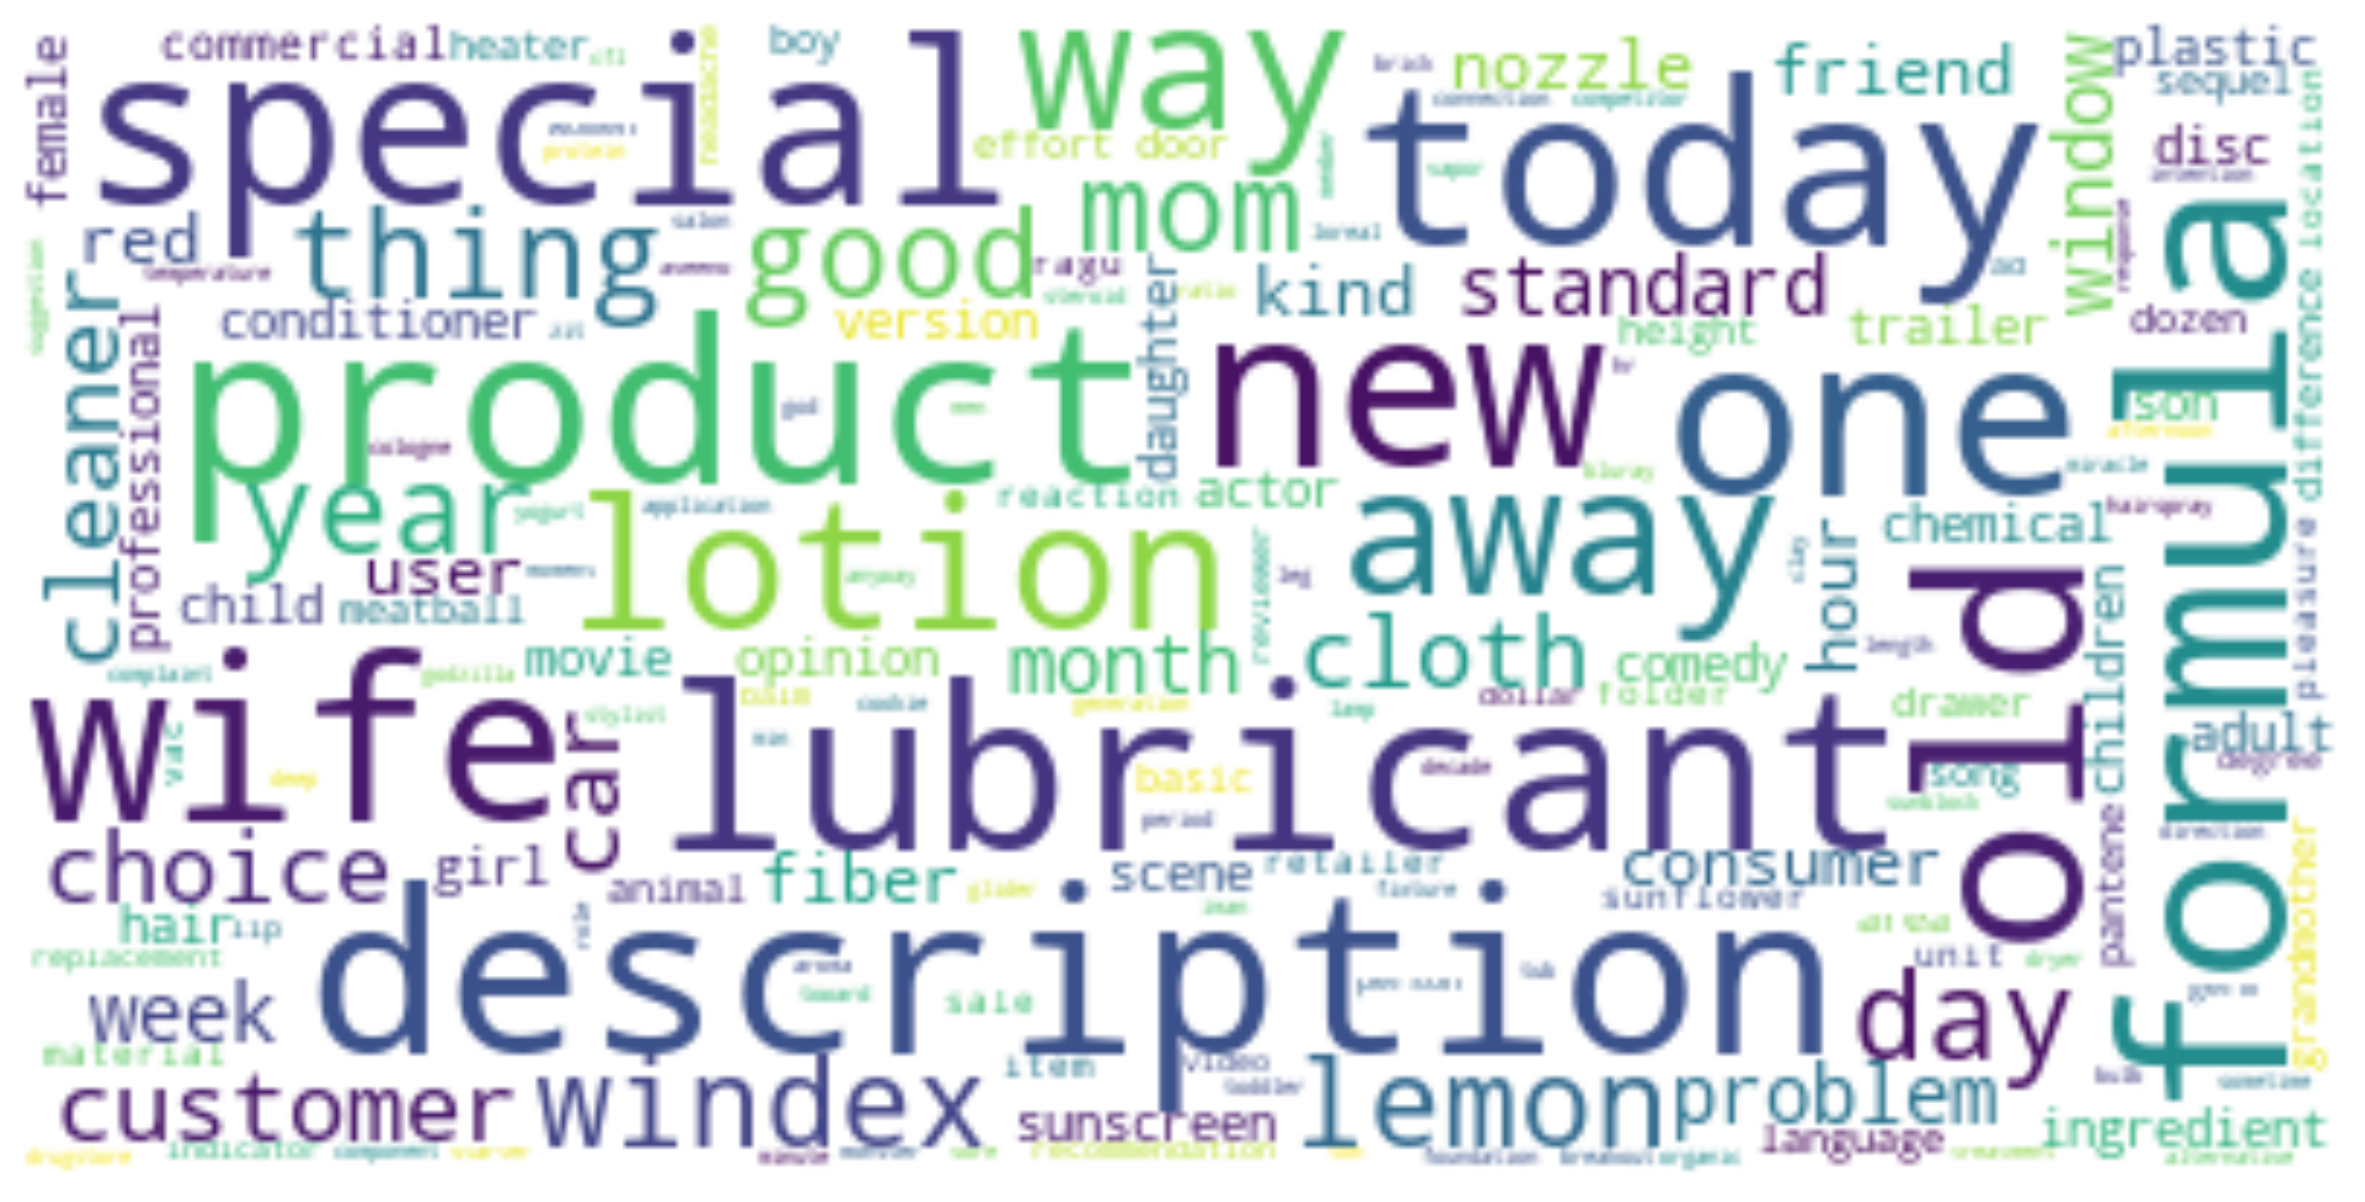

In [ ]:
import matplotlib as mpl
from wordcloud import WordCloud
all_words5 = Bag_Of_Words(ListWords1)
ax = plt.figure(figsize=(15,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',max_font_size=40).generate(' '.join(all_words5.keys()))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Combien de Mots !!!",len(all_words5))

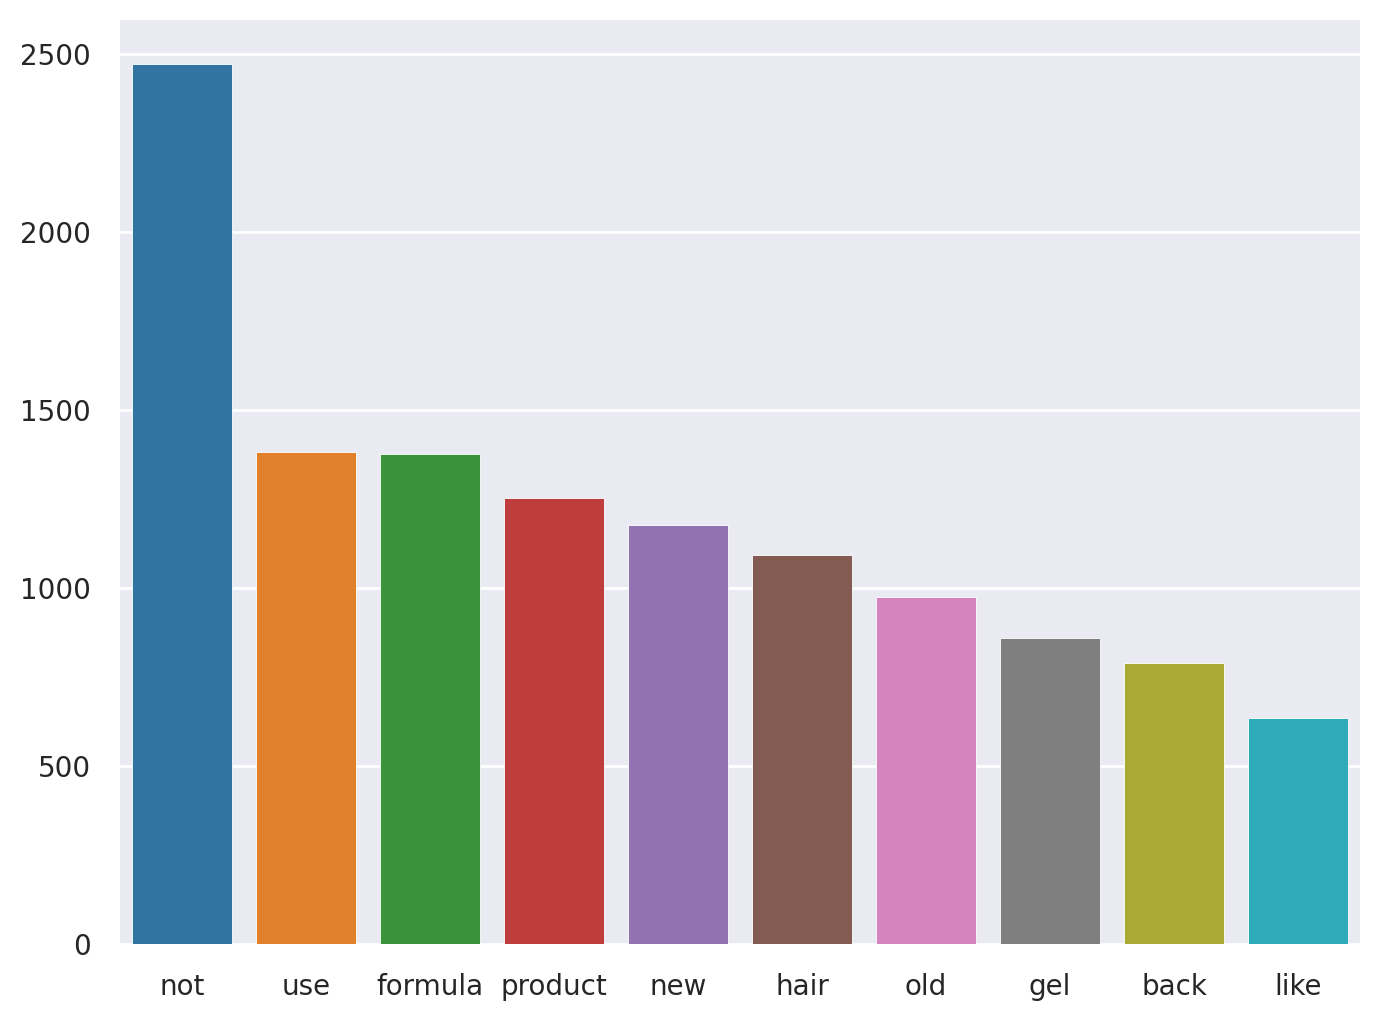

In [ ]:
plt.figure(figsize = (8,6))

import seaborn as sns
from sklearn.manifold import TSNE
all_words5 = Bag_Of_Words(ListWords1)
count = []
Words  = []
for w in all_words5.most_common(10):
    count.append(w[1])
    Words.append(w[0])
sns.set_style("darkgrid")
sns.barplot(Words,count)

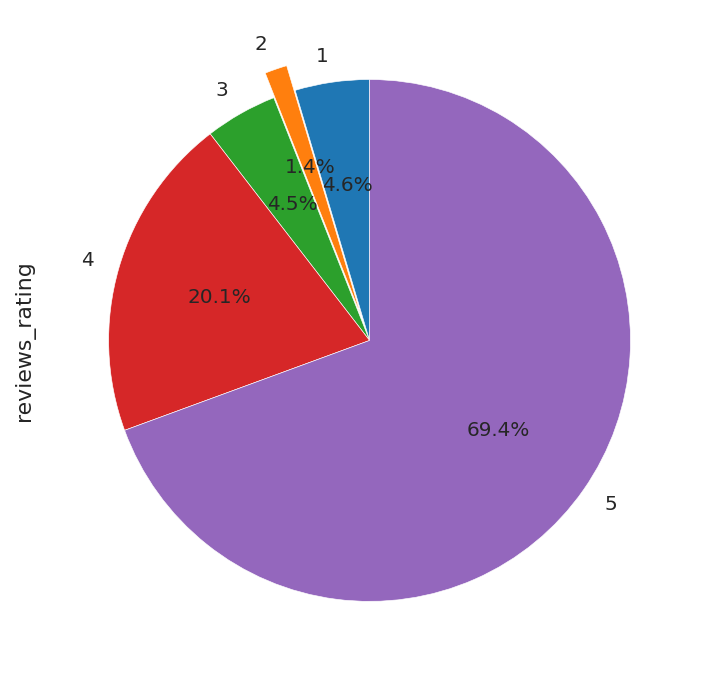

In [ ]:
%matplotlib inline
plt.figure(figsize = (10,6))

clean_data.groupby('reviews_rating').reviews_rating.count()
clean_data.groupby('reviews_rating').reviews_rating.count().plot(kind='pie',autopct='%1.1f%%',startangle=90,explode=(0,0.1,0,0,0),)

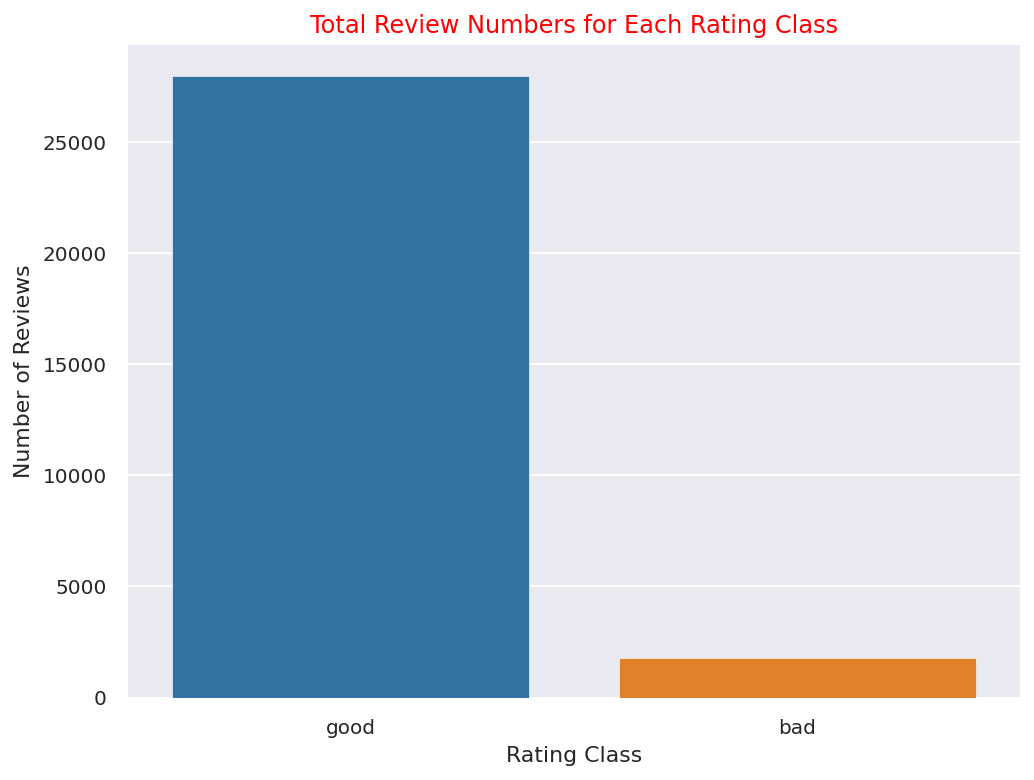

good    27955
bad      1779
Name: rating_class, dtype: int64

In [ ]:
# Total numbers of ratings in the home and kitchen product reviews
plt.figure(figsize = (8,6))
sns.countplot(clean_data['rating_class'])
plt.title('Total Review Numbers for Each Rating Class', color='r')
plt.xlabel('Rating Class')
plt.ylabel('Number of Reviews')
plt.show()

# Customer totals for each rating class
clean_data['rating_class'].value_counts()

In [ ]:
# Create a year column and drop time column
#df['reviewtime'] = pd.to_datetime(df['time'], format = '%Y %m %d')
# Create a "year" column and drop time column
clean_data['reviews_date'] = pd.to_datetime(clean_data['reviews_date'])
clean_data['reviews_year'] = clean_data['reviews_date'].dt.year
clean_data.drop('reviews_date', axis = 1,inplace=True)
clean_data.head(3)

id  ...                                  clean_reviewstext
0  AV13O1A8GV-KLJ3akUyj  ...  awesome love album good hip hop side current p...
1  AV14LG0R-jtxr-f38QfS  ...     good good flavor review collect part promotion
3  AV16khLE-jtxr-f38VFn  ...  disappoint read review look buy one couple lub...

[3 rows x 12 columns]

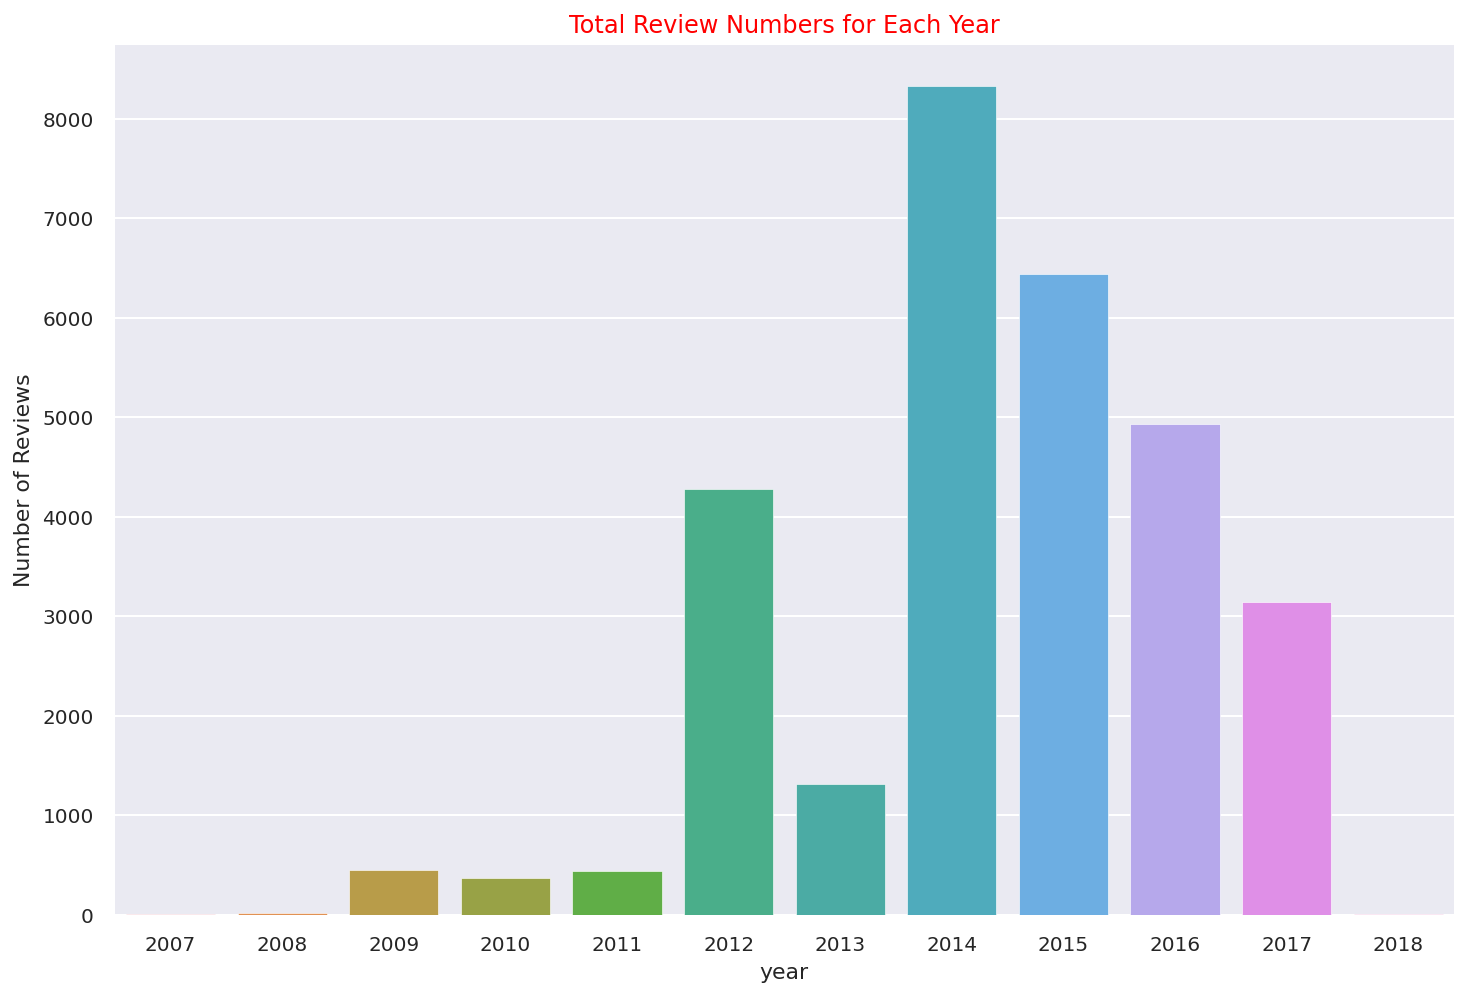

2014    8329
2015    6444
2016    4938
2012    4283
2017    3140
2013    1317
2009     447
2011     440
2010     363
2008      20
2007      10
2018       3
Name: reviews_year, dtype: int64

In [ ]:
##################################################################
# Total review for every year in the Headphone product
#####################################################################
plt.figure(figsize = (12,8))
sns.countplot(clean_data['reviews_year'])
plt.title('Total Review Numbers for Each Year', color='r')
plt.xlabel('year')
plt.ylabel('Number of Reviews')
plt.show()

# Customer totals for each rating class
clean_data['reviews_year'].value_counts()

Number of reviews are highest in year 2014

In [ ]:
# Check Number of unique customers

print('Number of unique customers: {}'.format(len(clean_data['reviews_username'].unique())))

Number of unique customers: 24869


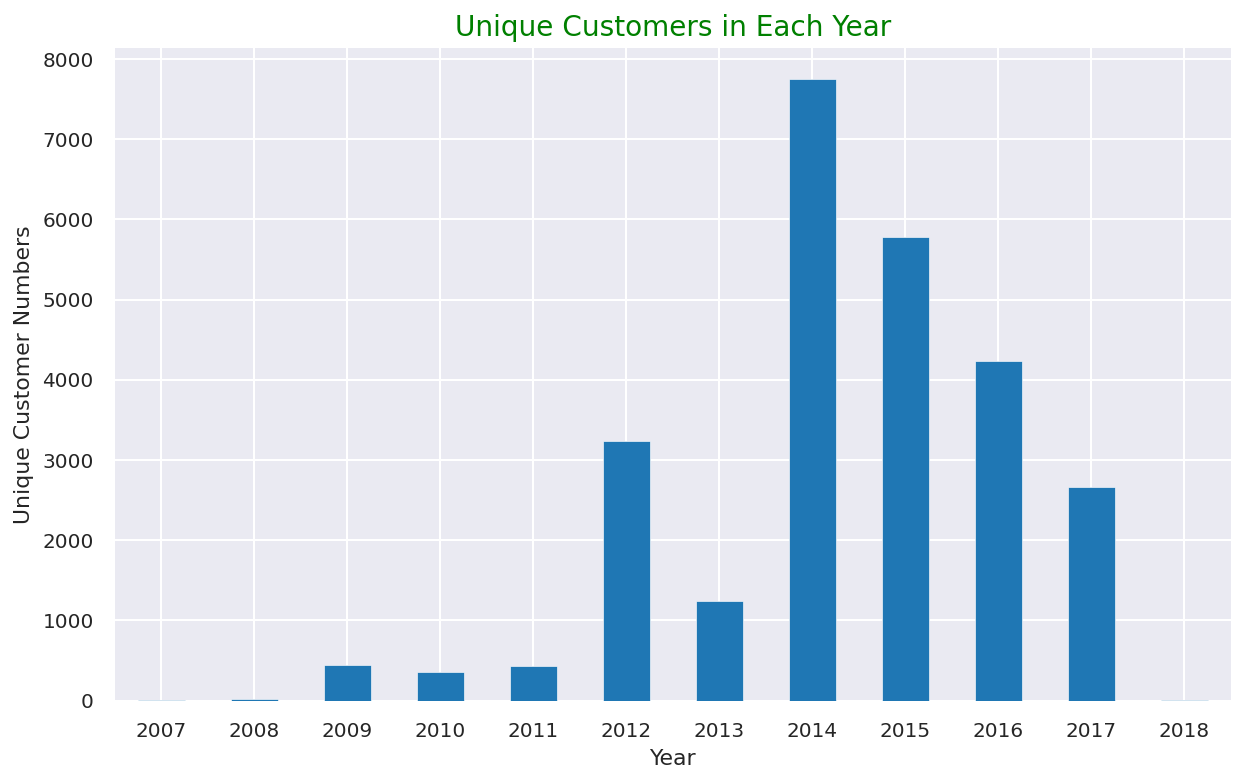

reviews_year
2007      10
2008      18
2009     446
2010     351
2011     436
2012    3236
2013    1239
2014    7747
2015    5787
2016    4230
2017    2663
2018       3
Name: reviews_username, dtype: int64


In [ ]:
# How many unique customers in each year?
unique_cust = clean_data.groupby('reviews_year')['reviews_username'].nunique()

# Plot unique customer numbers in each year
plt.figure(figsize = (10,6))
# unique_cust.plot(kind='bar', rot = 0, colors = 'b')

unique_cust.plot(kind='bar', rot = 0)
plt.title('Unique Customers in Each Year', color='g', size = 14)
plt.xlabel('Year')
plt.ylabel('Unique Customer Numbers')
plt.show()

# Print unique customer numbers in each year
print(unique_cust)

2014 is having highest number of unique review usernames

In [ ]:
# unique customers for each "rating class"
a = list(clean_data.groupby(['rating_class'])['reviews_username'].unique())  

# number of customers
a2 = [len(a[0]),len(a[1])] 

# number of reviews for each "rating class"
b = list(clean_data['rating_class'].value_counts())              

uniq_cust_rate = pd.DataFrame({'rating_class': ['bad', 'good'],
                               'number_of_customers': a2,
                               'number_of_reviews': sorted(b)})
print(uniq_cust_rate)

  rating_class  number_of_customers  number_of_reviews
0          bad                 1394               1779
1         good                23656              27955


* Number of customers and nummber of reviews for bad rating is less compared good rating class
* Hence we have class imbalance here

In [ ]:
print('Number of unique products: {}'.format(len(clean_data['name'].unique())))

Number of unique products: 268


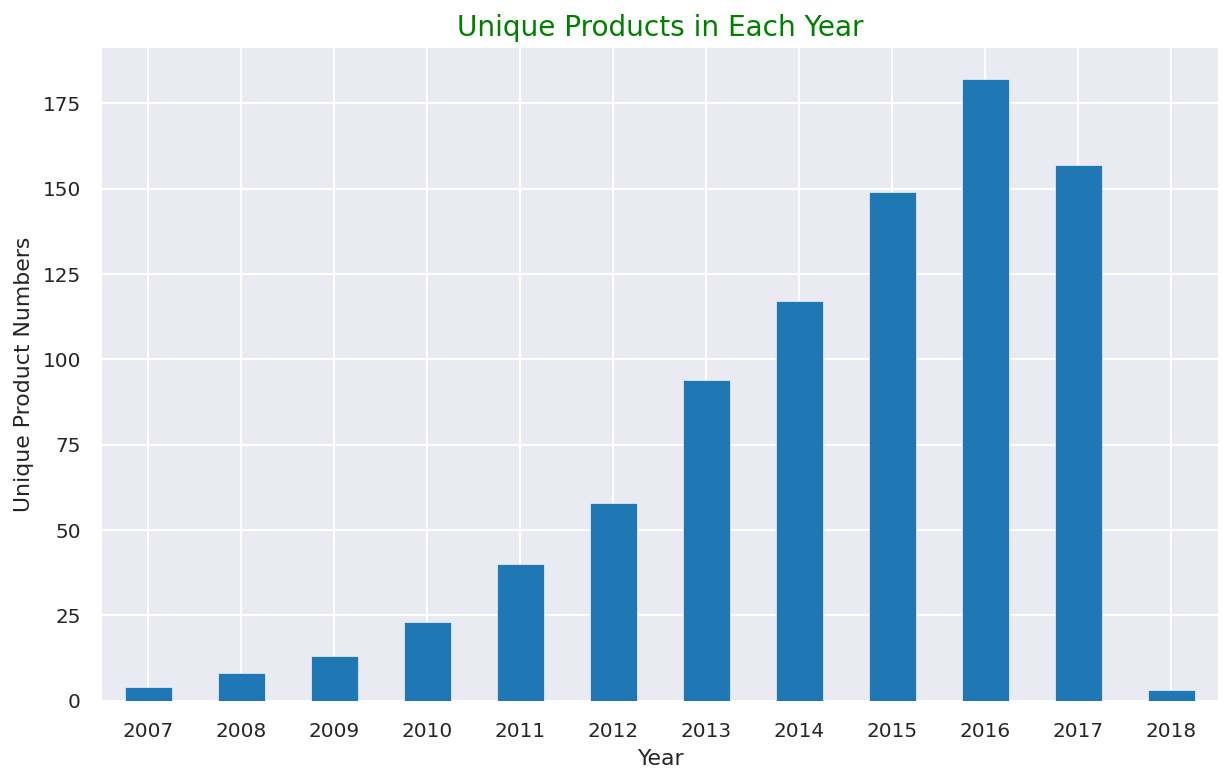

reviews_year
2007      4
2008      8
2009     13
2010     23
2011     40
2012     58
2013     94
2014    117
2015    149
2016    182
2017    157
2018      3
Name: name, dtype: int64


In [ ]:
# How many unique products in each year?
unique_prod = clean_data.groupby('reviews_year')['name'].nunique()

# Plot unique product numbers in each year
plt.figure(figsize = (10,6))
unique_prod.plot(kind='bar', rot =0)
plt.title('Unique Products in Each Year', color = 'g', size = 14)
plt.xlabel('Year')
plt.ylabel('Unique Product Numbers')
plt.show()

# Print unique product numbers in each year
print(unique_prod)

In 2016 we have highest reviews for unique products

Text(0, 0.5, 'Number of Reviews')

<Figure size 1080x576 with 0 Axes>

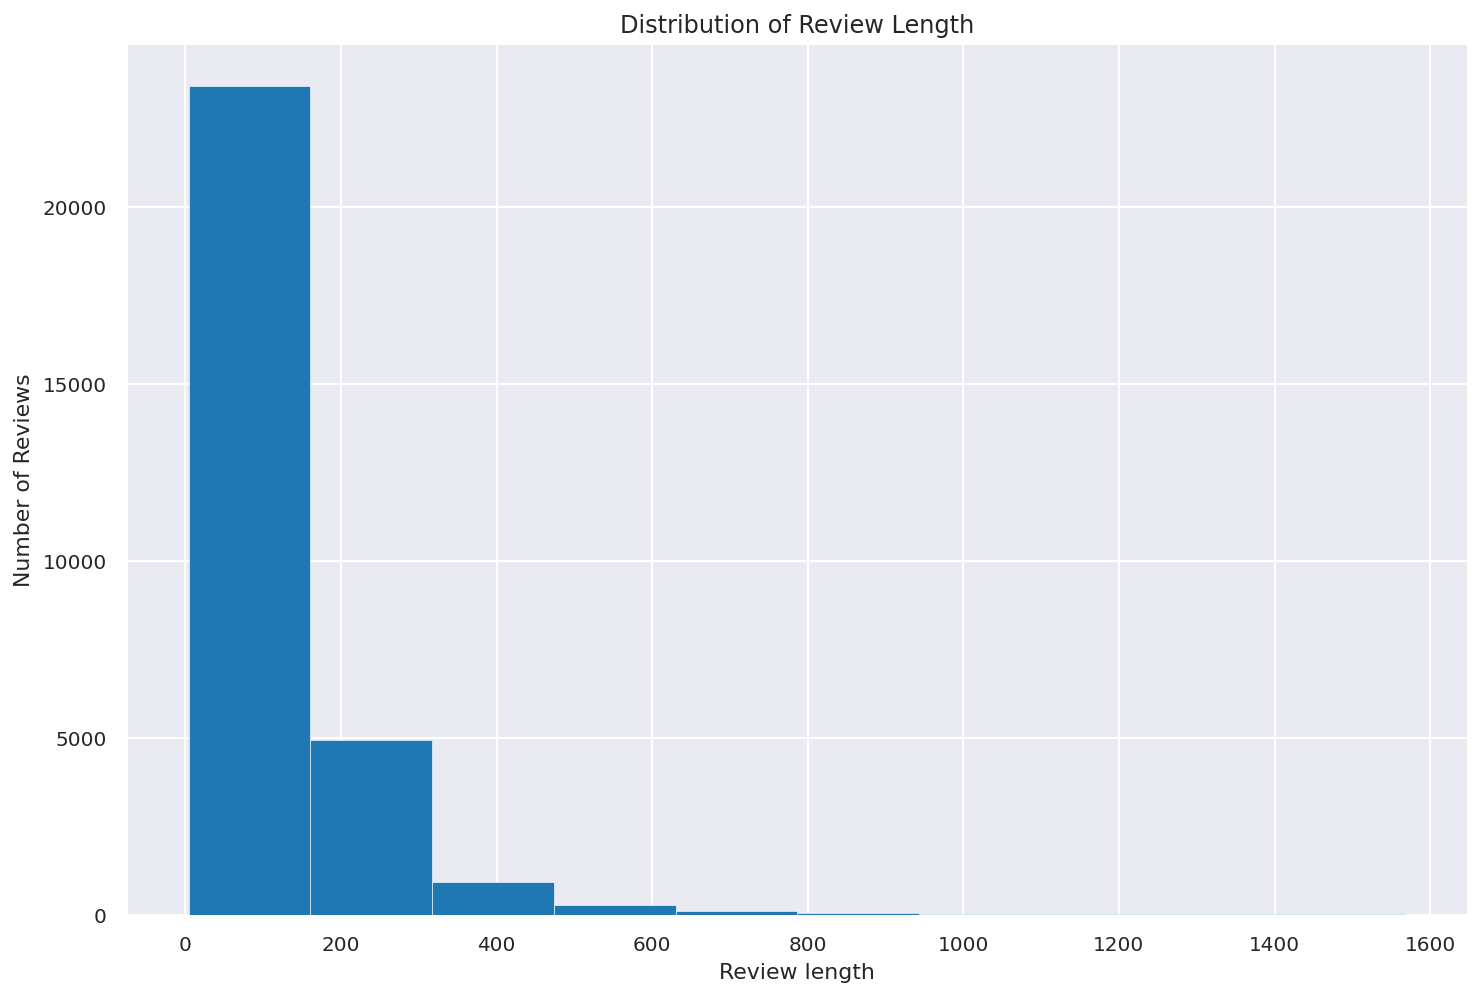

In [ ]:
##########################################
## PLOT DISTRIBUTION OF REVIEW LENGTH   
##########################################
plt.figure(figsize = (15,8))

review_length = clean_data["clean_reviewstext"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 2000].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length')
plt.ylabel('Number of Reviews')

Small reviews are more as compared to bigger review text

In [ ]:
# # Let's see how the rating classes change for each year in a table and graph.
# # Create a dataframe which shows the relationship between review numbers and rating classes for each year

# clean_data['rating_class_num'] = clean_data['rating_class'].map({'good': 1, 'bad': 0})
    
# feature = clean_data.groupby('reviews_year').agg({'rating_class_num':['size', 'sum', 'mean']})

# feature
# # feature.columns = [' '.join(col).strip() for col in feature.columns.values]
# # feature = feature.reset_index()
# # feature['rating_class_num mean'] = feature['rating_class_num mean']*100
# # feature.columns = ['Year', 'Total Reviews', 'Relevant Rating Number', 
# #                        '% of Relevant Rating Number in This Year'] 
# # feature['% of Relevant Rating in the Total'] = (feature['Relevant Rating Number'] / 22425)*100
        
# feature

In [ ]:
# Function for creating a column token
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

# To create token feature
clean_data['token'] = clean_data['clean_reviewstext'].apply(token)

In [ ]:
# Function for creating a column to see the length of the review text
def length(text):
    length = len([w for w in nltk.word_tokenize(text)])
    return length

# Apply length function to create review length feature
clean_data['reviews_length'] = clean_data['reviewstext'].apply(length)
clean_data.head(3)

id  ... reviews_length
0  AV13O1A8GV-KLJ3akUyj  ...             50
1  AV14LG0R-jtxr-f38QfS  ...             14
3  AV16khLE-jtxr-f38VFn  ...            144

[3 rows x 14 columns]

In [ ]:
# Create review length bin feature
clean_data['review_length_bin'] = pd.cut(clean_data['reviews_length'], np.arange(0,4800,100))
clean_data.head()

id            brand  ... reviews_length review_length_bin
0  AV13O1A8GV-KLJ3akUyj  Universal Music  ...             50          (0, 100]
1  AV14LG0R-jtxr-f38QfS         Lundberg  ...             14          (0, 100]
3  AV16khLE-jtxr-f38VFn              K-Y  ...            144        (100, 200]
4  AV16khLE-jtxr-f38VFn              K-Y  ...             30          (0, 100]
5  AV16khLE-jtxr-f38VFn              K-Y  ...             58          (0, 100]

[5 rows x 15 columns]

In [ ]:
# Good rating percentages for each length bin with 50's

clean_data['rating_class_num'] = clean_data['rating_class'].map({'good': 1, 'bad': 0})

per_pos_length = clean_data.groupby(['review_length_bin'])['rating_class_num'].mean()
clean_data['review_length_bin'] = clean_data.review_length_bin.astype(str)
per_pos_length = per_pos_length*100
per_pos_length


review_length_bin
(0, 100]         94.967474
(100, 200]       78.609626
(200, 300]       79.274611
(300, 400]       84.782609
(400, 500]       80.000000
(500, 600]       75.000000
(600, 700]             NaN
(700, 800]             NaN
(800, 900]             NaN
(900, 1000]            NaN
(1000, 1100]    100.000000
(1100, 1200]    100.000000
(1200, 1300]           NaN
(1300, 1400]           NaN
(1400, 1500]           NaN
(1500, 1600]           NaN
(1600, 1700]           NaN
(1700, 1800]           NaN
(1800, 1900]           NaN
(1900, 2000]           NaN
(2000, 2100]           NaN
(2100, 2200]           NaN
(2200, 2300]           NaN
(2300, 2400]           NaN
(2400, 2500]           NaN
(2500, 2600]           NaN
(2600, 2700]           NaN
(2700, 2800]           NaN
(2800, 2900]           NaN
(2900, 3000]           NaN
(3000, 3100]           NaN
(3100, 3200]           NaN
(3200, 3300]           NaN
(3300, 3400]           NaN
(3400, 3500]           NaN
(3500, 3600]           NaN
(3600, 370

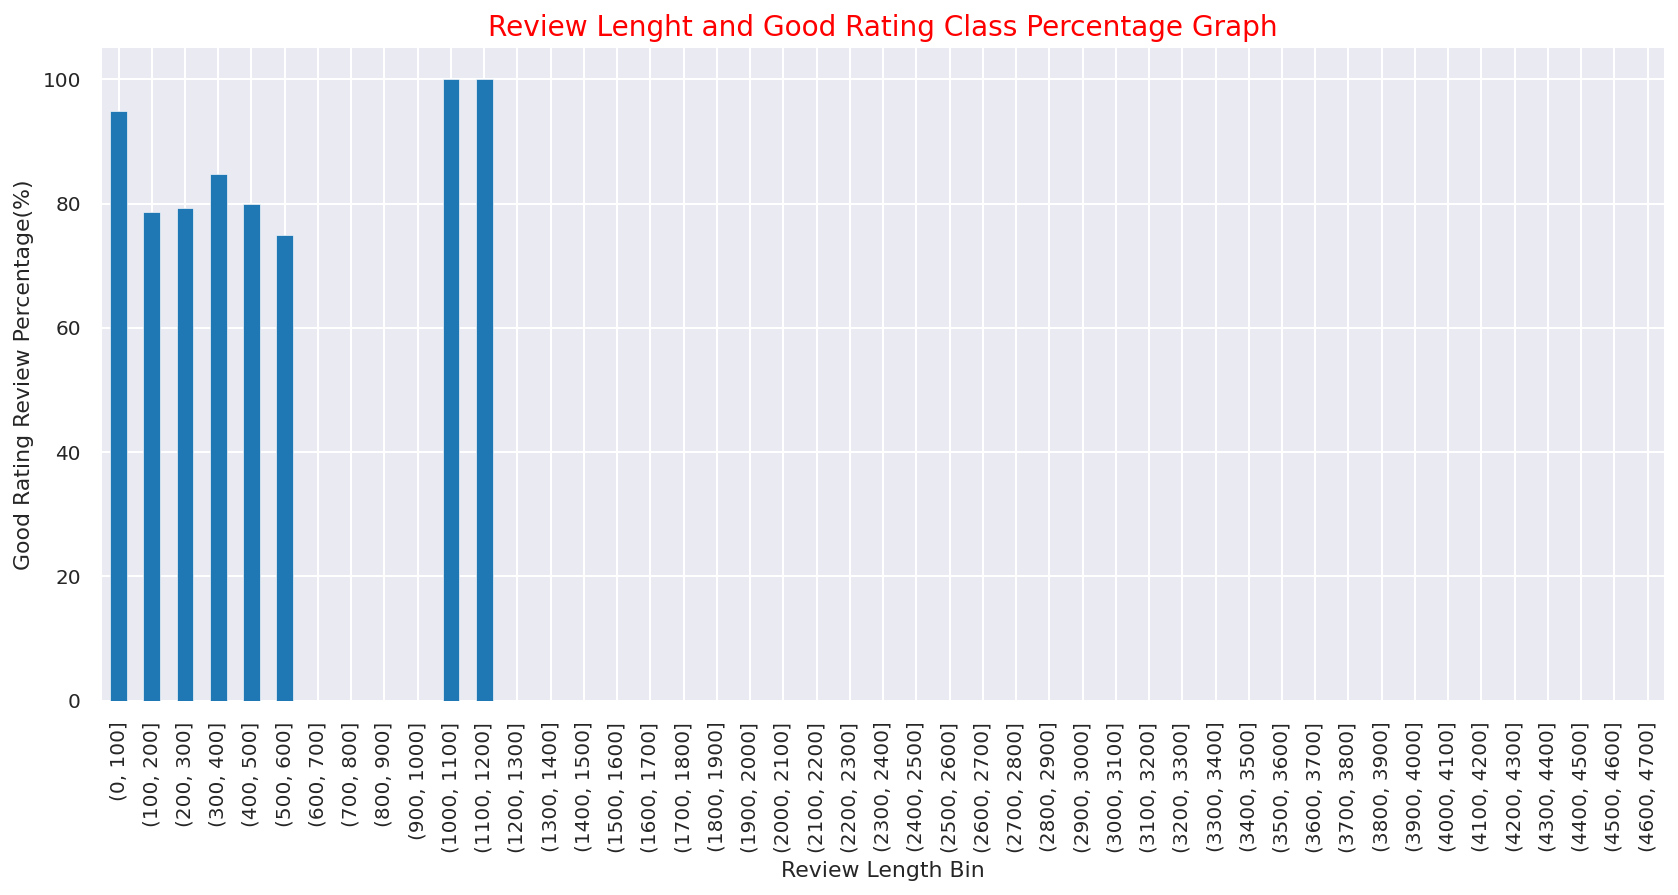

In [ ]:
# Plot the graph for good rating class percentage and review length bin
plt.figure(figsize = (14,6))
per_pos_length.plot(kind='bar')
plt.title('Review Lenght and Good Rating Class Percentage Graph', color = 'r', size = 14)
plt.xlabel('Review Length Bin')
plt.ylabel('Good Rating Review Percentage(%)')
plt.show()

As we see highest good rating percentage lies between (1000, 1100) and (1100,1200) with 100%

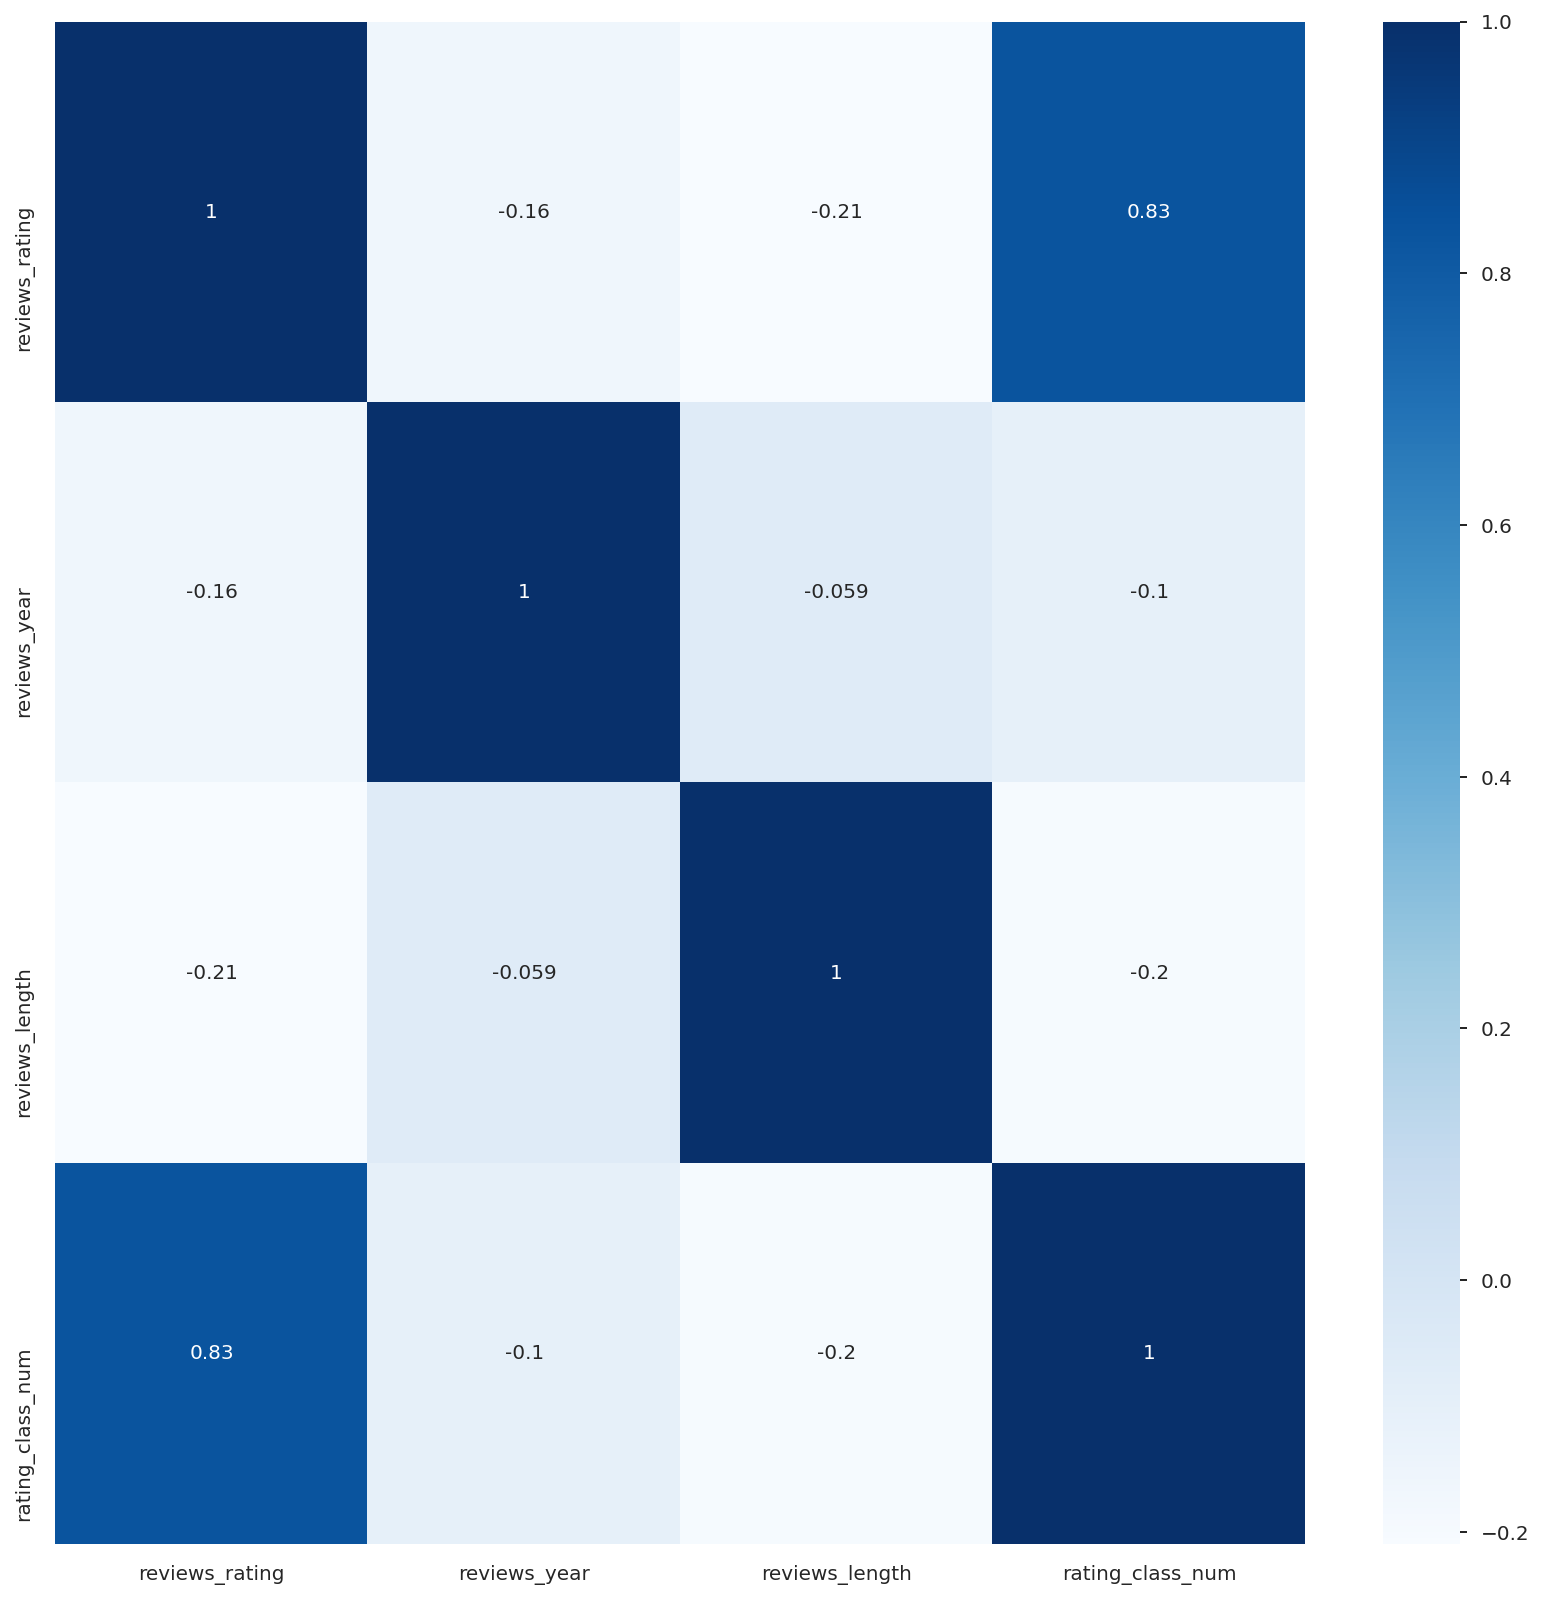

In [ ]:
# Plotting correlation matrix between numeric variables

plt.figure(figsize = (14,14))
sns.heatmap(clean_data.corr(method="pearson"), cmap='Blues', annot = True)

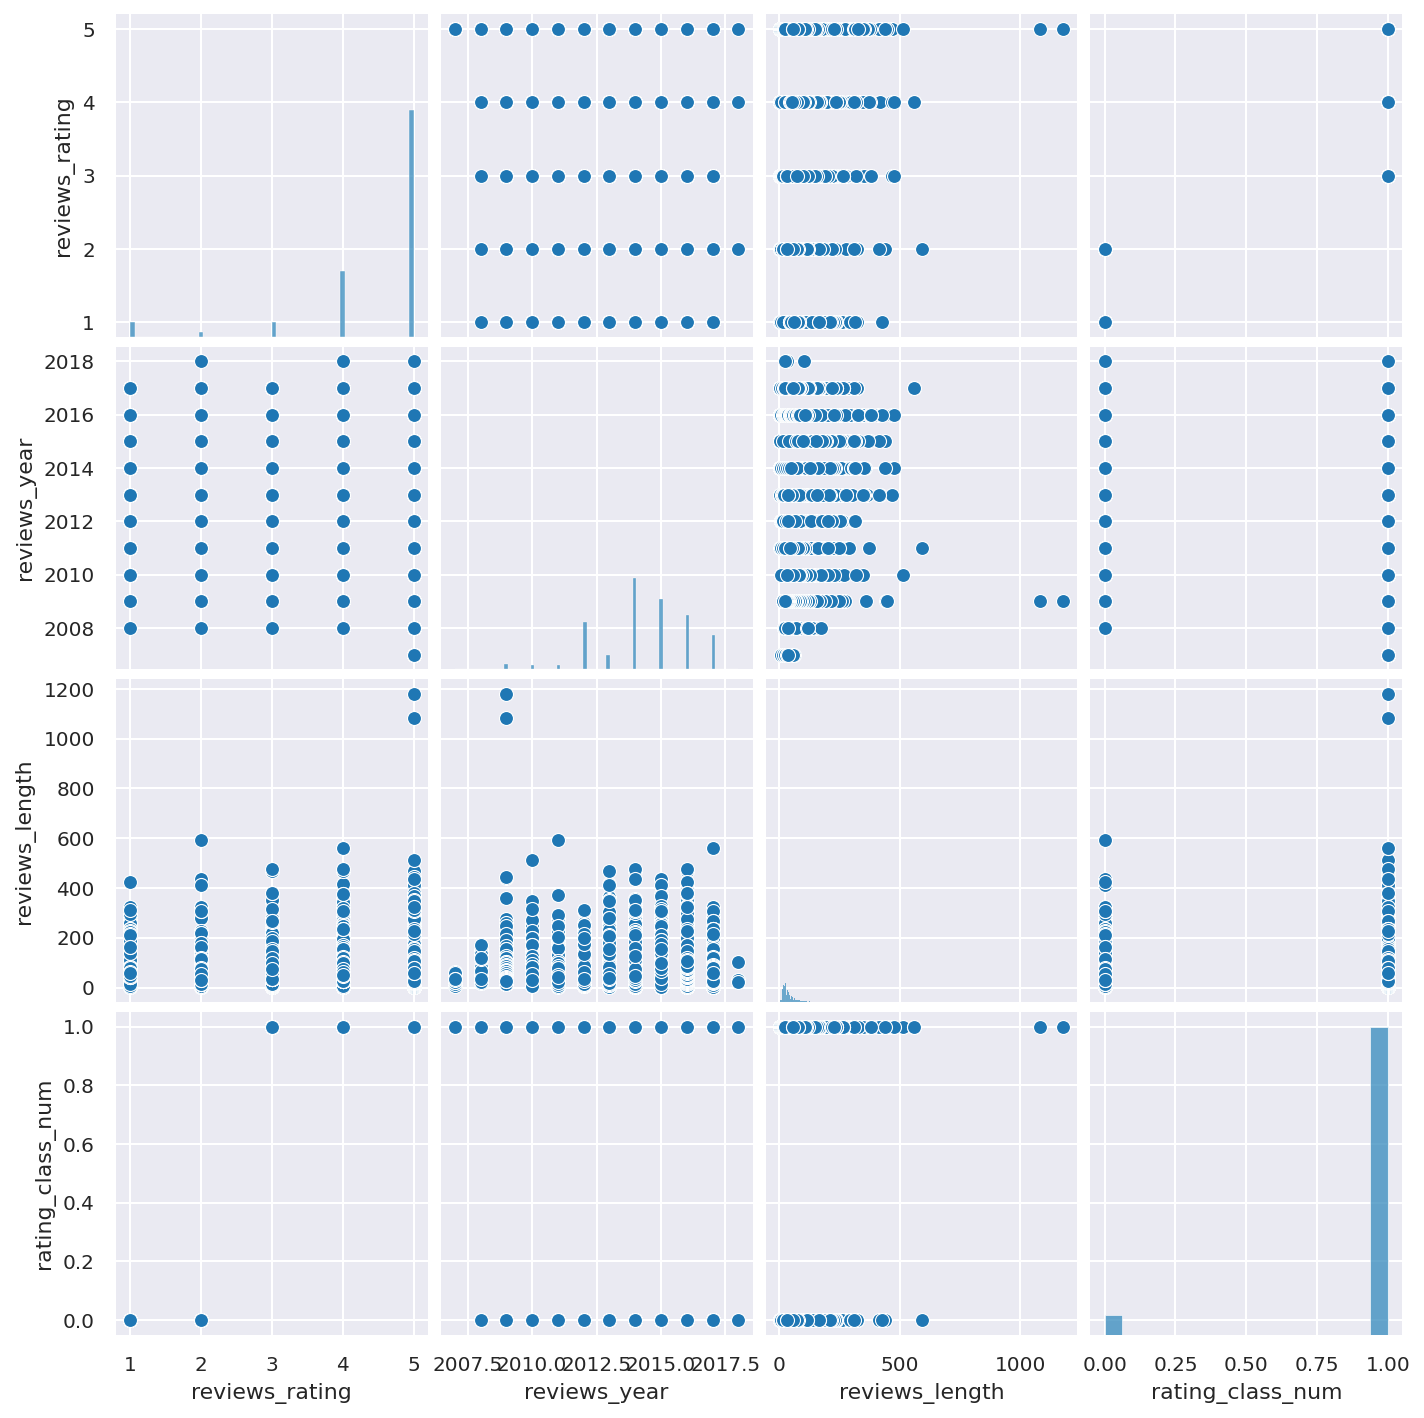

In [ ]:
sns.pairplot(clean_data)

In [ ]:
### Due to computational considerations, I will reduce the number of observations. I will drop good rating class reviews longer than 150 words, and I will drop all observations earlier than year 2009.

In [ ]:
data4 = clean_data.drop(clean_data[(clean_data['reviews_length'] > 150) & (clean_data['rating_class'] == 'good')].index)

Save cleaned file for Sentimental Analysis 

In [ ]:
data4.to_csv('/content/drive/MyDrive/Data/reduced_clean_sample30.csv', sep=',', encoding='utf-8', index = False)

Perform EDA on God and Bad words

In [ ]:
data5 = data4.drop(data4[(data4['reviews_year'] < 2009)].index)
data5=data5.head(5000)
data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 5233
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5000 non-null   object
 1   brand              5000 non-null   object
 2   categories         5000 non-null   object
 3   manufacturer       5000 non-null   object
 4   name               5000 non-null   object
 5   reviews_rating     5000 non-null   int64 
 6   reviews_username   5000 non-null   object
 7   user_sentiment     5000 non-null   object
 8   reviewstext        5000 non-null   object
 9   reviews_year       5000 non-null   int64 
 10  rating_class       5000 non-null   object
 11  clean_reviewstext  5000 non-null   object
 12  token              5000 non-null   object
 13  reviews_length     5000 non-null   int64 
 14  review_length_bin  5000 non-null   object
 15  rating_class_num   5000 non-null   int64 
dtypes: int64(4), object(12)
memory usage: 664.

In [ ]:
data5.shape

(5000, 16)

In [ ]:
data6 = data5[["clean_reviewstext", "rating_class_num"]].reset_index()
data6.head(10)

index                                  clean_reviewstext  rating_class_num
0      0  awesome love album good hip hop side current p...                 1
1      1     good good flavor review collect part promotion                 1
2      3  disappoint read review look buy one couple lub...                 0
3      4  irritation husband buy gel us gel cause irrita...                 0
4      5  not worth boyfriend buy spice things bedroom h...                 0
5      6  disappoint buy earlier today excite check base...                 0
6      7  not happy buy product husband try not impress ...                 0
7      8  disappoint husband buy extra fun werevboth ext...                 0
8      9  not buy get surprise husband nothing special l...                 0
9     10  pretty dissapoitned try husband felt no differ...                 0

In [ ]:
# Initialize the countervectorizer
countVec = CountVectorizer(ngram_range=(1, 2),binary=True)

In [ ]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              5000 non-null   int64 
 1   clean_reviewstext  5000 non-null   object
 2   rating_class_num   5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [ ]:
# Fit the 'clean_text' to countvectorizer
countVec.fit(data6["clean_reviewstext"])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
# Transform the matriz
transformed_matrix = countVec.transform(data6["clean_reviewstext"])

In [ ]:
# Convert matrix to array
transformed_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Extracting the feature names
names = countVec.get_feature_names()

In [ ]:
# Adding a 'rating' column from previous dataframe's rating value
data7 = pd.DataFrame(transformed_matrix.toarray(), columns=names)
data7['rating'] = data6['rating_class_num']

In [ ]:
data7['rating'].head()

0    1
1    1
2    0
3    0
4    0
Name: rating, dtype: int64

In [ ]:
# Create lists for forming a dataframe summary
feature_names = []
avg_ratings = [] 
rating_counts = []
for name in names:
    if name != 'rating':    
        avg_rating = data7[data7[name]== 1]['rating'].mean()
        rating_count = data7[data7[name]== 1]['rating'].count()
        feature_names.append(name)
        avg_ratings.append(avg_rating)
        rating_counts.append(rating_count)  
    else:
        pass

In [ ]:
##### Create a new dataframe from words, average ratings, and rating counts
df_summary = pd.DataFrame({'feature_name':feature_names, 'avg_rating': avg_ratings, 'rating_count':rating_counts})

In [ ]:
# Let's see the new dataframe
df_summary

feature_name  avg_rating  rating_count
0                    aaa         1.0             1
1         aaa production         1.0             1
2      aaaaaaaaaaaaaaaaa         1.0             1
3            aaaaahhhhhh         1.0             1
4              abilities         1.0             1
...                  ...         ...           ...
54628                zoo         1.0             1
54629          zoo house         1.0             1
54630             zorbas         1.0             1
54631           zucchini         1.0             1
54632   zucchini carrots         1.0             1

[54633 rows x 3 columns]

#### Good rating words

In [ ]:
# Words that are commonly used in the reviews which have good ratings
df_good = df_summary.query("rating_count > 20").sort_values(by='avg_rating', ascending=False)[4:50]
df_good.head(50)

feature_name  avg_rating  rating_count
15513             feel good         1.0            29
15282             fat greek         1.0            55
8016               comedies         1.0            22
15278                   fat         1.0            62
15000          family movie         1.0            34
41871            set movies         1.0            22
41853             set great         1.0            33
8391             compliment         1.0            27
8476              condition         1.0            26
30504              must see         1.0            27
31273                nicely         1.0            22
41576               sequels         1.0            27
8880           continue use         1.0            21
30050          movies great         1.0            43
29914           movie watch         1.0            53
16060                 final         1.0            36
17319             fragrance         1.0            37
27718            make laugh         1.0            24
36629         product great         1.0            51
45422            story line         1.0            29
27801             make skin         1.0            63
17364             franchise         1.0            37
44757                stairs         1.0            41
17248               forward         1.0            25
29713            movie love         1.0            64
6203                   cast         1.0            85
29542             movie buy         1.0            21
29663           movie great         1.0           126
43476           smell amaze         1.0            23
43179             skin soft         1.0            34
29674       movie hilarious         1.0            42
31544                   non         1.0            24
31688              not beat         1.0            25
31772        not disappoint         1.0            37
35852              powerful         1.0            36
10399        deep hydration         1.0            86
35344                 plaza         1.0            21
10519  definitely recommend         1.0            29
21840             hilarious         1.0           177
35546                pocket         1.0            28
38261          really enjoy         1.0            43
10955                  diet         1.0            28
38824               refresh         1.0            27
12527              easy use         1.0            54
37782               quickly         1.0            54
36058          pretty funny         1.0            30

In [ ]:
wc_good = dict(zip(df_good['feature_name'].tolist(), df_good['avg_rating'].tolist()))

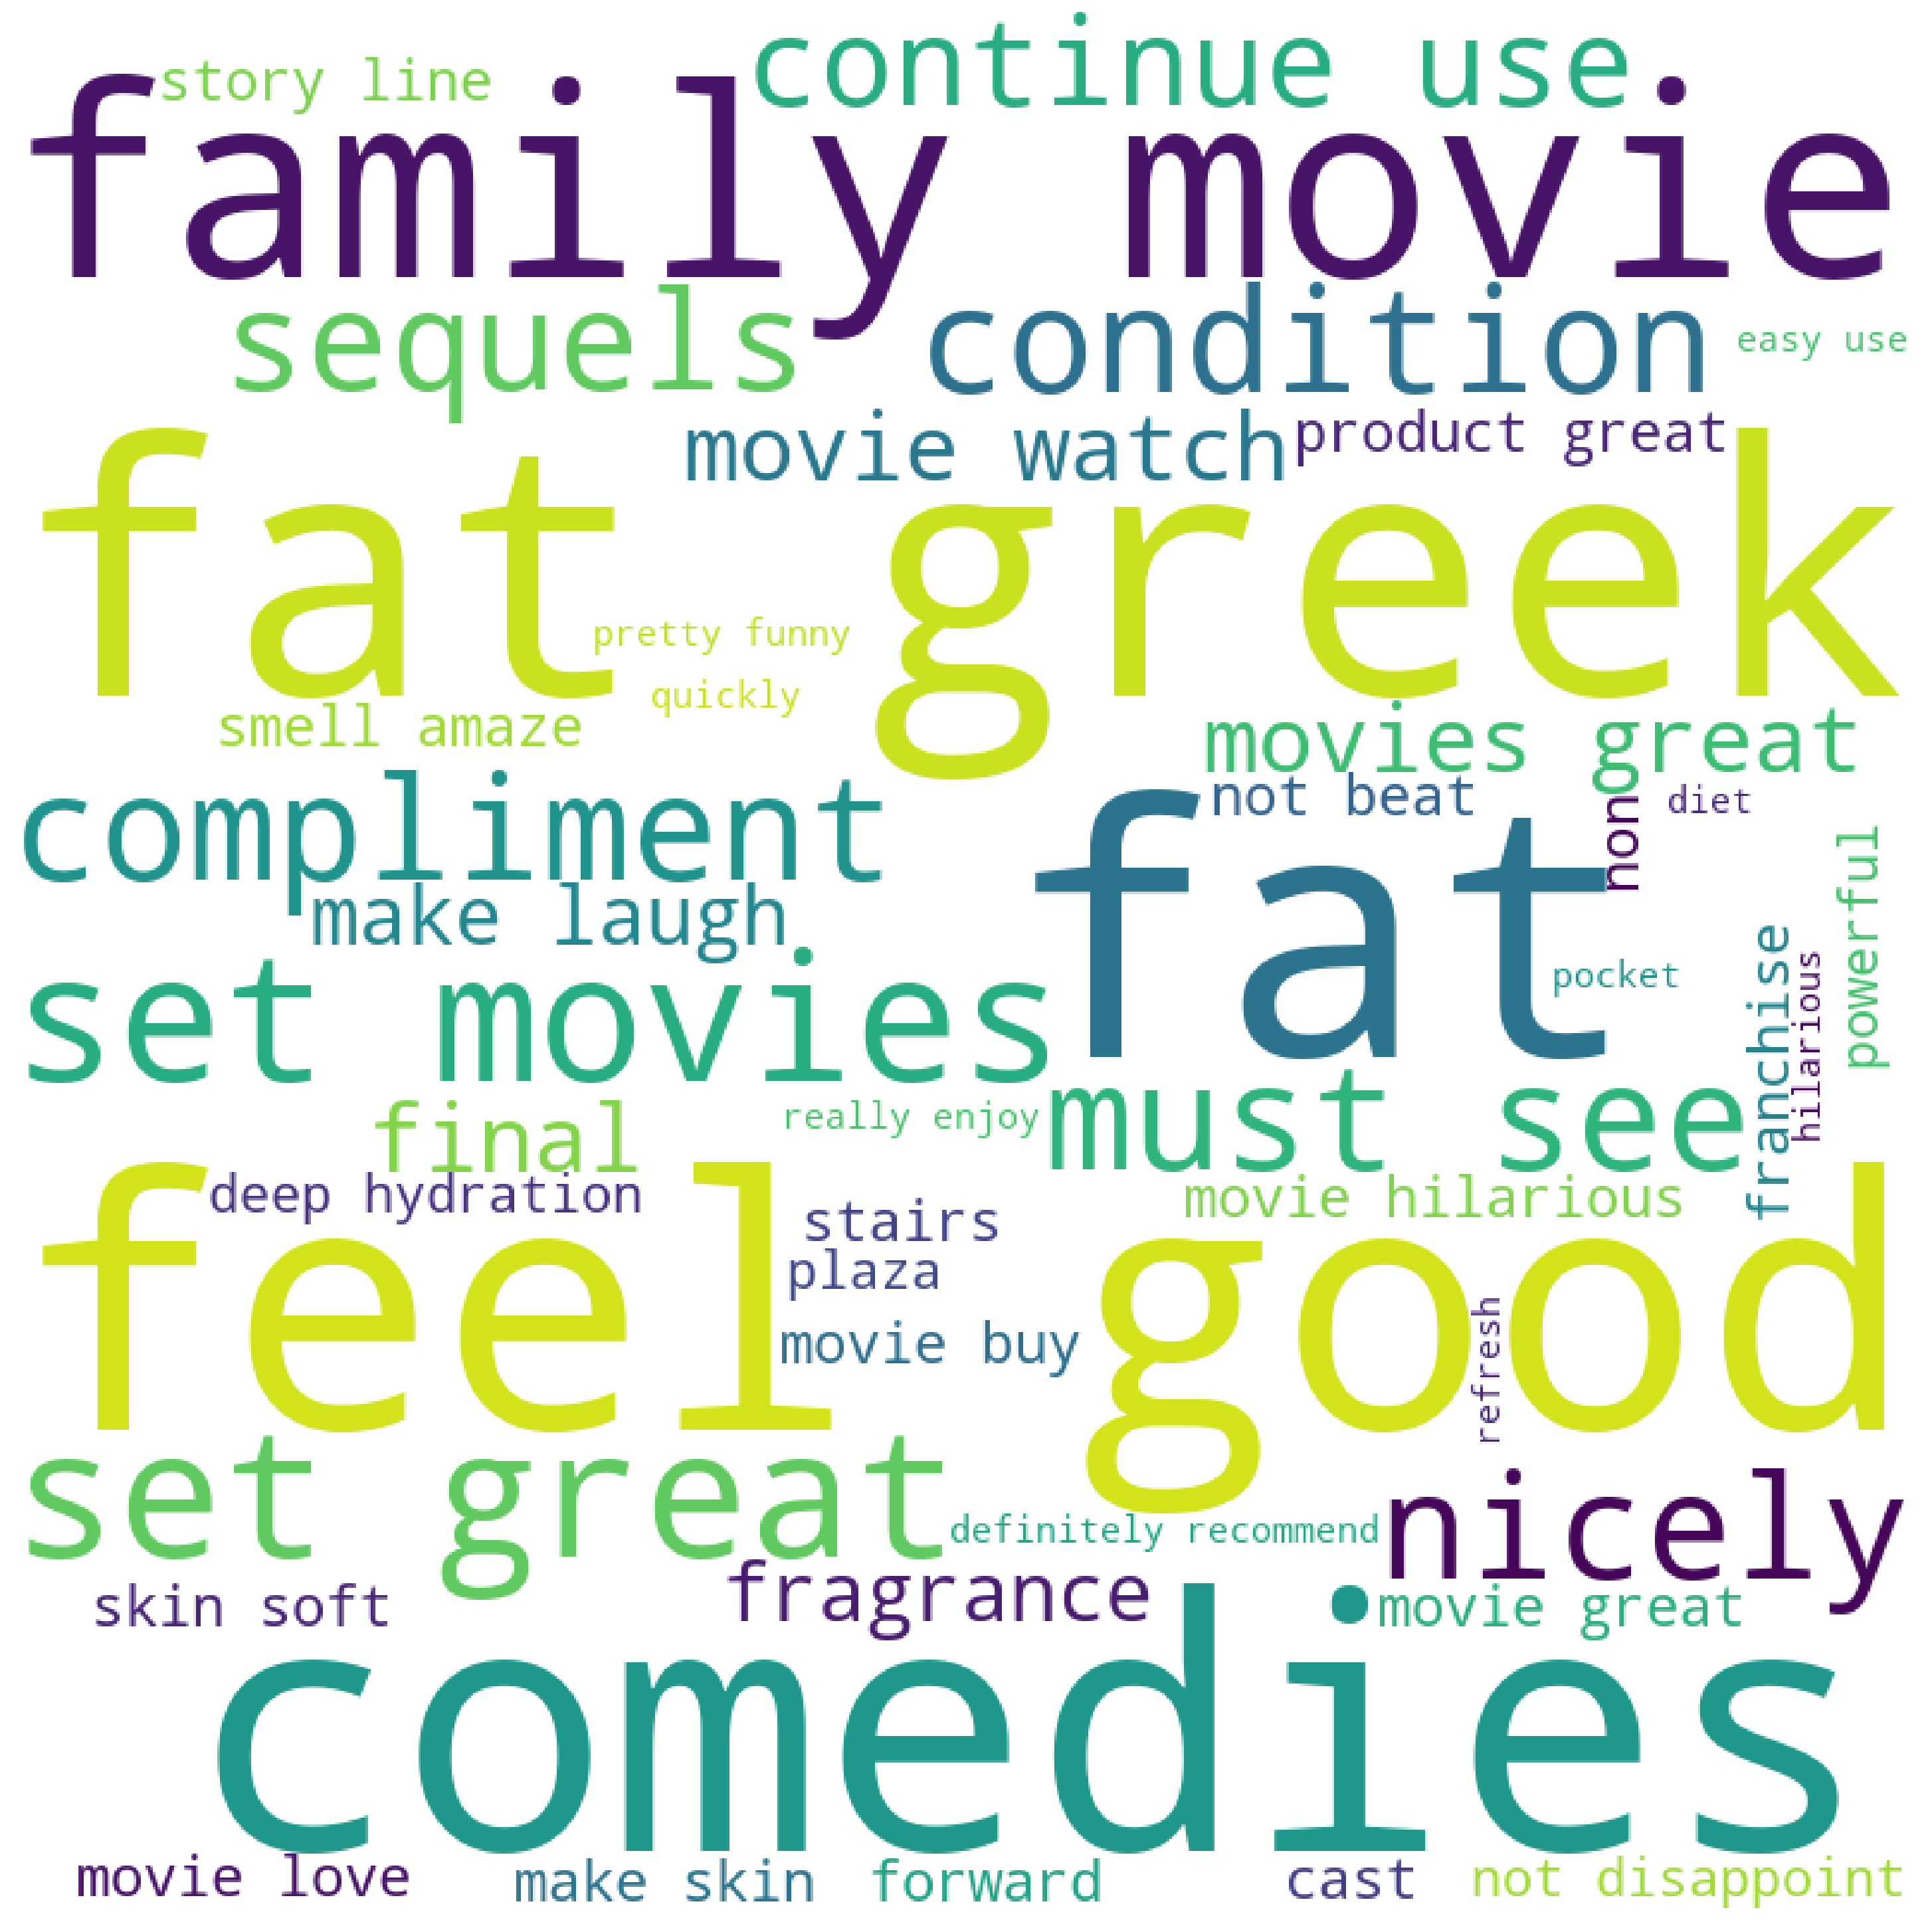

In [ ]:

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(wc_good)
 
# plot the WordCloud image                       
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Bad rating words


In [ ]:
# Words that are commonly used in the reviews which have bad ratings
df_bad = df_summary.query("rating_count > 10").sort_values(by= 'avg_rating', ascending=True)[:12]

In [ ]:
df_bad.sort_values(by=['avg_rating'],ascending=False,inplace=True)
df_bad

feature_name  avg_rating  rating_count
47163       terrible    0.363636            22
5321            burn    0.357143            14
31711        not buy    0.342857            35
42567           shut    0.333333            12
32188      not worth    0.333333            12
34364    paper towel    0.291667            24
22320       horrible    0.285714            14
17183        formula    0.285714            42
32040  not recommend    0.280000            25
48608          towel    0.280000            25
51648          waste    0.269231            26
49553  unfortunately    0.230769            13

In [ ]:
wc_bad = dict(zip(df_bad['feature_name'].tolist(), df_bad['avg_rating'].tolist()))

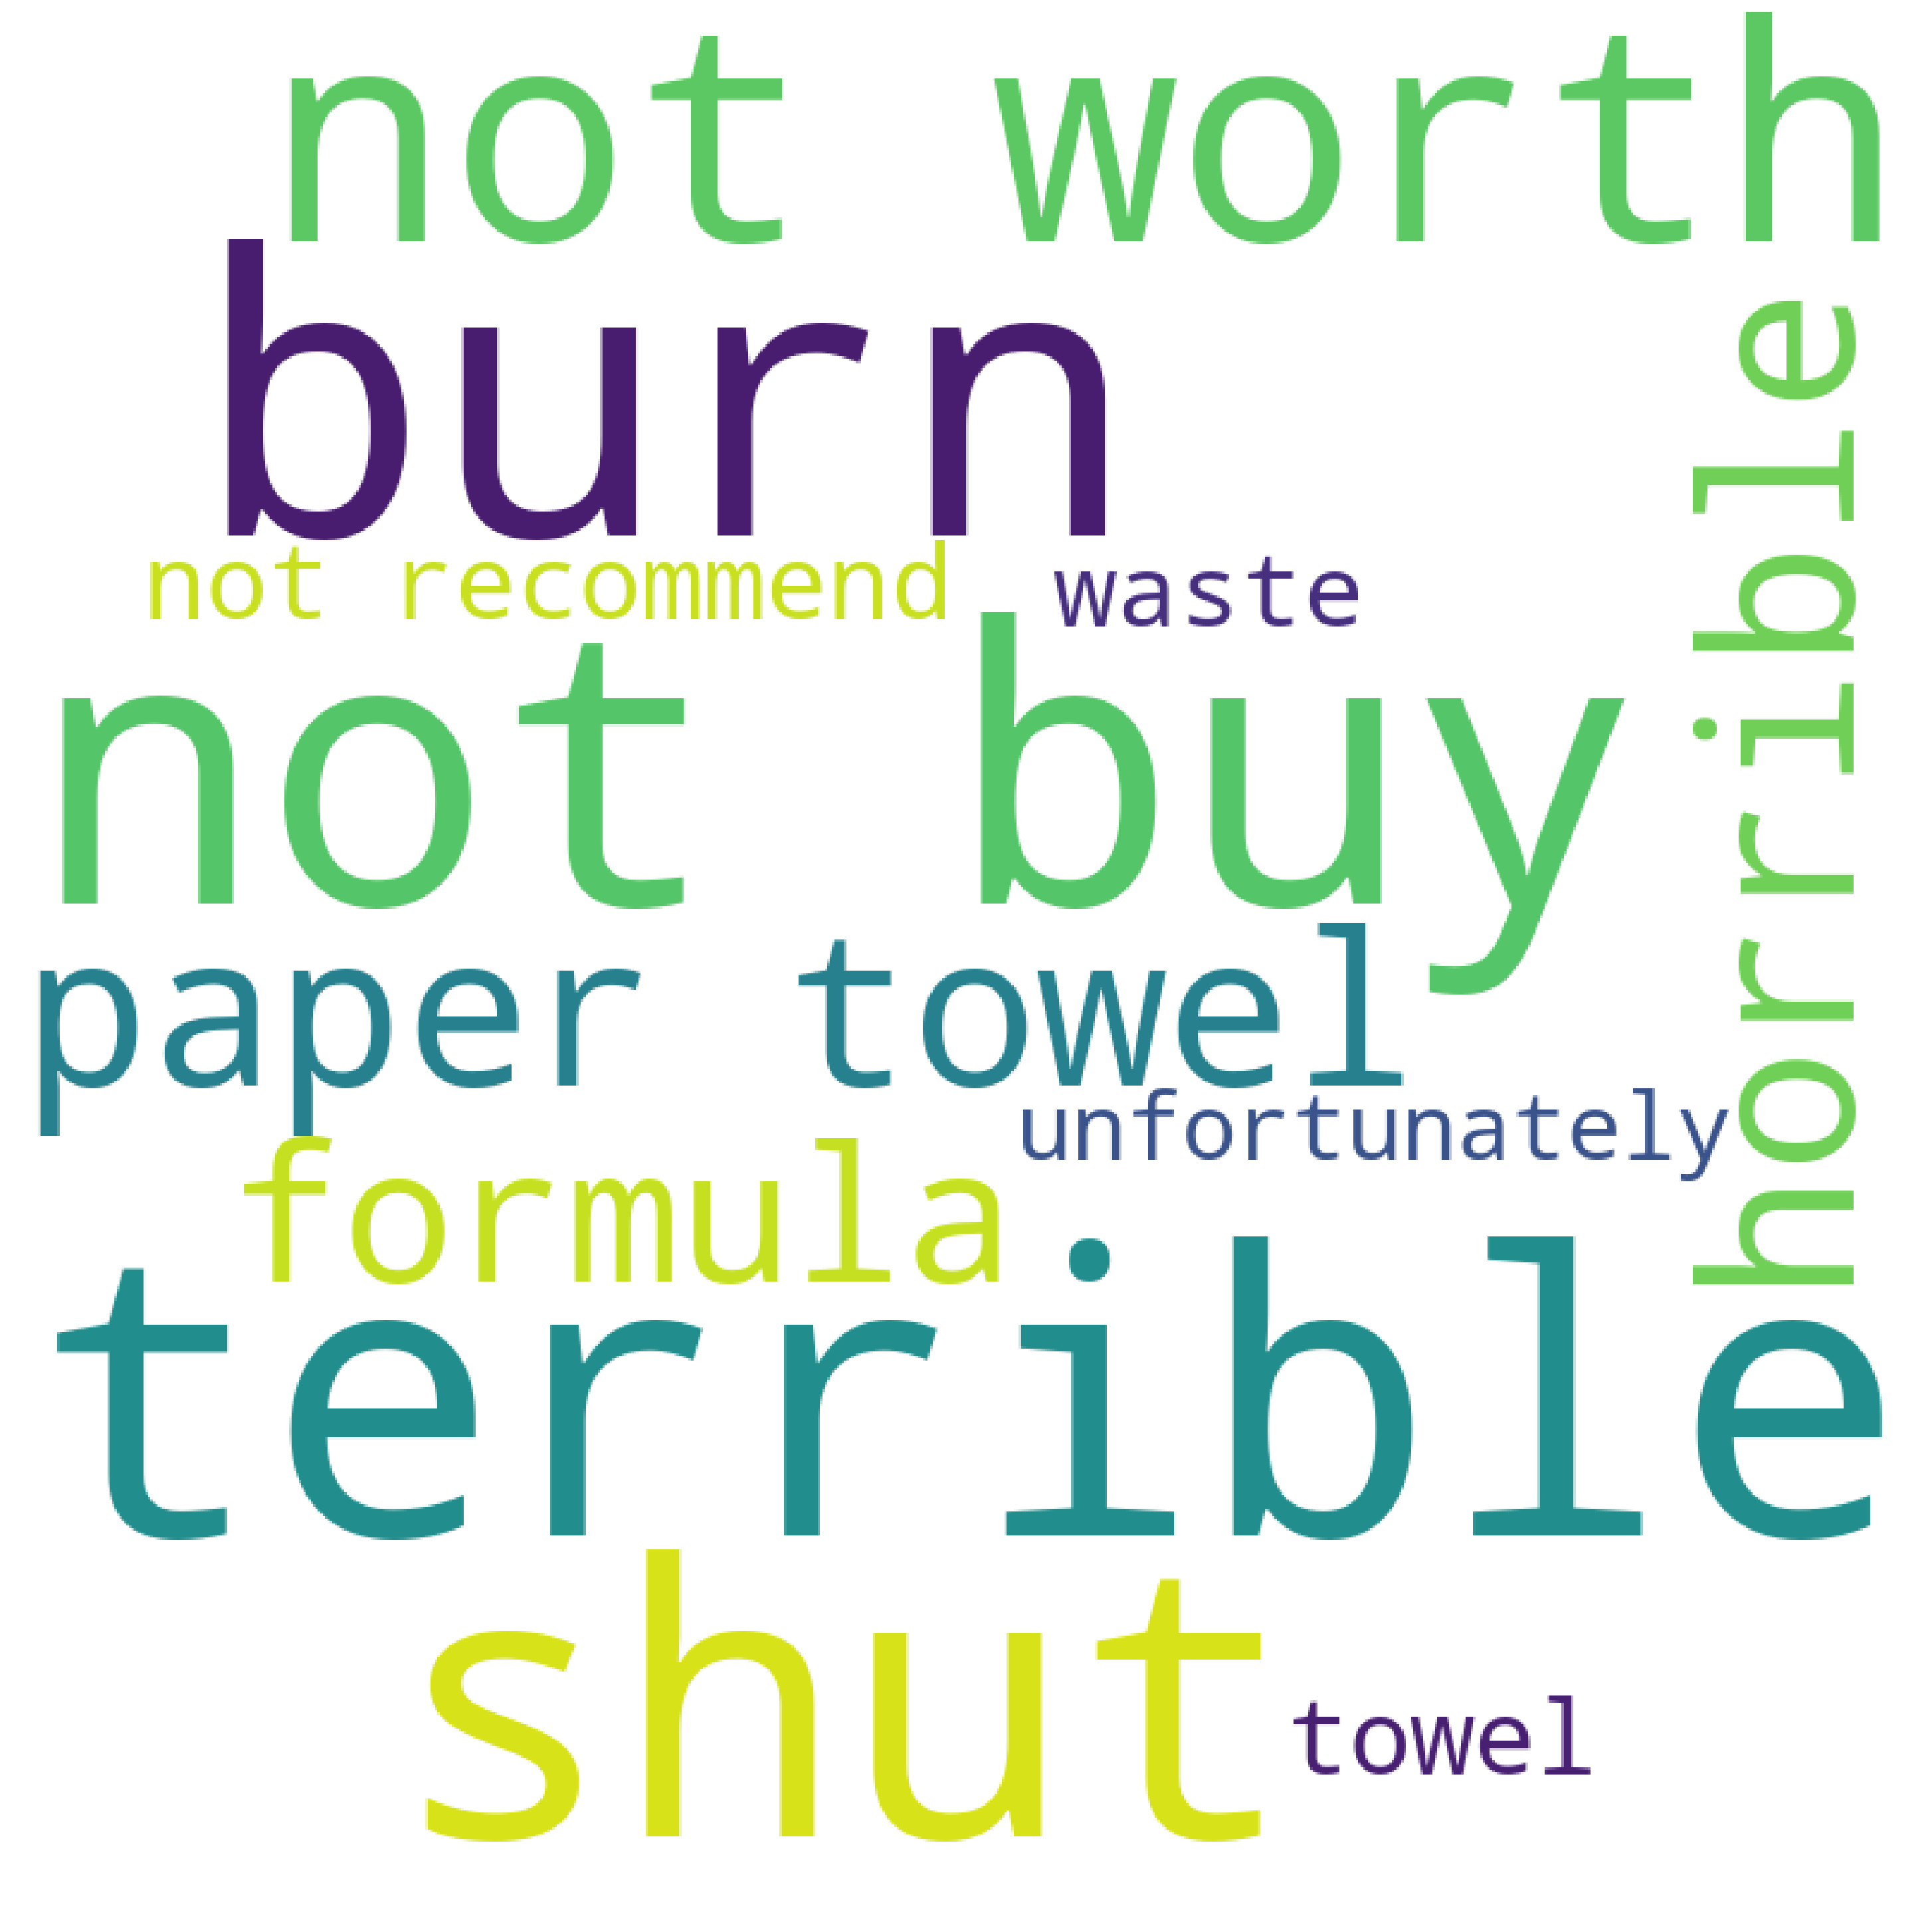

In [ ]:
# Generate a word cloud image

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(wc_bad)
 
# plot the WordCloud image                       
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Sentiment Analysis (Count Vectorizer and TF-IDF Vectorizer) 

### Import necessary libraries

In [55]:
!pip3 install catboost

In [56]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [57]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

### Reading the Cleaned Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Read the file
df3 = pd.read_csv('/content/drive/MyDrive/Data/reduced_clean_sample30.csv')



In [59]:
# Sample observations
df3.head(3)

id            brand  ... review_length_bin rating_class_num
0  AV13O1A8GV-KLJ3akUyj  Universal Music  ...          (0, 100]                1
1  AV14LG0R-jtxr-f38QfS         Lundberg  ...          (0, 100]                1
2  AV16khLE-jtxr-f38VFn              K-Y  ...        (100, 200]                0

[3 rows x 16 columns]

In [60]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29245 entries, 0 to 29244
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 29245 non-null  object
 1   brand              29245 non-null  object
 2   categories         29245 non-null  object
 3   manufacturer       29245 non-null  object
 4   name               29245 non-null  object
 5   reviews_rating     29245 non-null  int64 
 6   reviews_username   29245 non-null  object
 7   user_sentiment     29244 non-null  object
 8   reviewstext        29245 non-null  object
 9   reviews_year       29245 non-null  int64 
 10  rating_class       29245 non-null  object
 11  clean_reviewstext  29245 non-null  object
 12  token              29245 non-null  object
 13  reviews_length     29245 non-null  int64 
 14  review_length_bin  29245 non-null  object
 15  rating_class_num   29245 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 3.

In [61]:
df_back = df3

In [9]:
# Reducing number of rows due to computational constraints

# df3 = df3.head(20000)

In [62]:
# Drop unnecessary columns
df4 = df3.drop(['id','reviews_rating','categories','manufacturer','user_sentiment','brand','rating_class_num','reviews_length','review_length_bin'], axis=1)



In [63]:
df_good = df4[df4['rating_class']== 'good']

In [64]:
df_good.shape

(27466, 7)

In [65]:
df_bad = df4[df4['rating_class']== 'bad']

In [66]:
df_bad.shape

(1779, 7)

In [67]:
df_bad.head()

name  ...                                              token
2  K-Y Love Sensuality Pleasure Gel  ...  ['disappoint', 'read', 'review', 'look', 'buy'...
3  K-Y Love Sensuality Pleasure Gel  ...  ['irritation', 'husband', 'buy', 'gel', 'us', ...
4  K-Y Love Sensuality Pleasure Gel  ...  ['not', 'worth', 'boyfriend', 'buy', 'spice', ...
5  K-Y Love Sensuality Pleasure Gel  ...  ['disappoint', 'buy', 'earlier', 'today', 'exc...
6  K-Y Love Sensuality Pleasure Gel  ...  ['not', 'happy', 'buy', 'product', 'husband', ...

[5 rows x 7 columns]

We see class imbalance between good and bad ratings. Due to computational constraints lets reduce some good rating data and apply smote for class imbalance

In [68]:
df_good = df_good.head(15000)

In [69]:
from sklearn.utils import shuffle
df_comb = pd.concat([df_good,df_bad])
df_comb = shuffle(df_comb)

In [70]:
df_comb.head()

name  ...                                              token
6309   Clorox Disinfecting Wipes Value Pack Scented 1...  ...  ['good', 'right', 'purpose', 'disinfect', 'wip...
1102              Aussie Aussome Volume Shampoo, 13.5 Oz  ...  ['great', 'product', 'use', 'shampoo', 'every'...
10910  Clorox Disinfecting Wipes Value Pack Scented 1...  ...  ['awesome', 'product', 'love', 'leave', 'wipe'...
5585                    Red (special Edition) (dvdvideo)  ...  ['great', 'ride', 'bunch', 'older', 'actors', ...
7011   Clorox Disinfecting Wipes Value Pack Scented 1...  ...  ['clorox', 'wipe', 'love', 'product', 'time', ...

[5 rows x 7 columns]

In [71]:
df_comb.shape

(16779, 7)

In [72]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16779 entries, 6309 to 12836
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               16779 non-null  object
 1   reviews_username   16779 non-null  object
 2   reviewstext        16779 non-null  object
 3   reviews_year       16779 non-null  int64 
 4   rating_class       16779 non-null  object
 5   clean_reviewstext  16779 non-null  object
 6   token              16779 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers.

We will implement CounterVectorizer, TF-IDF, Hash Vectorizer, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

### Separating Response Variable and Feature

In [73]:
df_comb['rating_class'] = df_comb['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [74]:
# Splitting the Data Set into Train and Test Sets
X = df_comb['clean_reviewstext']
y = df_comb['rating_class']

In [75]:
X.head()

6309     good right purpose disinfect wipe great quick ...
1102     great product use shampoo every day shower sme...
10910    awesome product love leave wipe every room hou...
5585     great ride bunch older actors play part older ...
7011     clorox wipe love product time save make little...
Name: clean_reviewstext, dtype: object

In [76]:
from imblearn.over_sampling import SMOTE

In [77]:
smote = SMOTE(random_state=42)

### Splitting Dataset into Train and Test Set

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [78]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [79]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(12584,)
Test Set Shape		:(4195,)


## 3. Selecting the Right Evaluation Metric

Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

### Confusion Matrix Plot Function

Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [81]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.

Since the ratings of the reviews were not distributed normally, I decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Bad’ and Rating 3-4-5 as 'Good'.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

## 4.1 CountVectorizer Bag of Words

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class.

In [82]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [83]:
X_train.head()

7205     clorox wipe love product super cconvenient dis...
13556    mrs home daycare clorox wipe convenient trust ...
2760     great movie great movie good first movie saw c...
2998     great laptop dell inspiron great light nice si...
7789     love know use product disinfection do review c...
Name: clean_reviewstext, dtype: object

In [84]:
count_vect_train_sm , y_train_sm = smote.fit_sample(count_vect_train,y_train)

In [30]:
y_train_sm.shape

(22506,)

In [31]:
count_vect_train_sm.shape

(22506, 9594)

In [85]:
import pickle
pickle.dump(count_vect, open('transform_cv.pkl', 'wb'))

In [86]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 9492


In [87]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [88]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train_sm, columns = vocab).head()

aaa  aaaaaaaaaaaaaaaaa  aalot  aanyhwere  ...  zoo  zorbas  zucchini  zyrtec
0    0                  0      0          0  ...    0       0         0       0
1    0                  0      0          0  ...    0       0         0       0
2    0                  0      0          0  ...    0       0         0       0
3    0                  0      0          0  ...    0       0         0       0
4    0                  0      0          0  ...    0       0         0       0

[5 rows x 9492 columns]

### Creating a function for applying different algorithms

In [89]:

def modeling(Model, Xtrain = count_vect_train_sm, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train_sm)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
    return model

### Dummy Classifier

In [ ]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.8059766389316562


In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.10      0.09      0.10       462
           1       0.89      0.90      0.89      3733

    accuracy                           0.81      4195
   macro avg       0.50      0.50      0.50      4195
weighted avg       0.80      0.81      0.81      4195



### 4.1.1 Logistic Regression with CountVectorizer

In [ ]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
Logistic_cv = modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9559116783845869


#### Classification Report

In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       462
           1       0.98      0.96      0.97      3733

    accuracy                           0.95      4195
   macro avg       0.87      0.92      0.89      4195
weighted avg       0.96      0.95      0.96      4195



#### Confusion Matrix

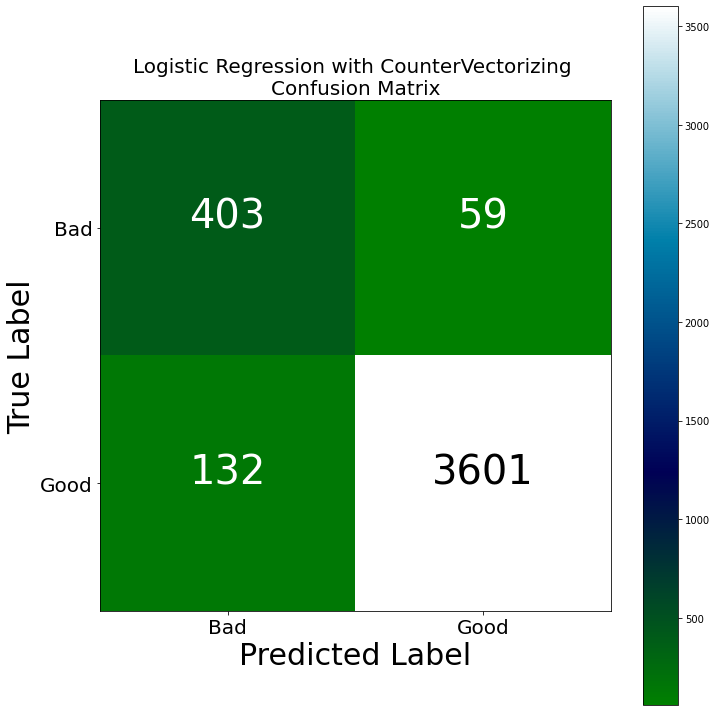

In [ ]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

In [ ]:
# Save the model
import pickle
filename = 'Logistic_cv_sm.pkl'
pickle.dump(Logistic_cv, open(filename, 'wb'))

### 4.1.2 Random Forest with CountVectorizer¶

In [ ]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
Random_cv = modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.9534478663320968


#### Classification Report

In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       462
           1       0.98      0.97      0.97      3733

    accuracy                           0.95      4195
   macro avg       0.87      0.89      0.88      4195
weighted avg       0.95      0.95      0.95      4195



#### Confusion Matrix

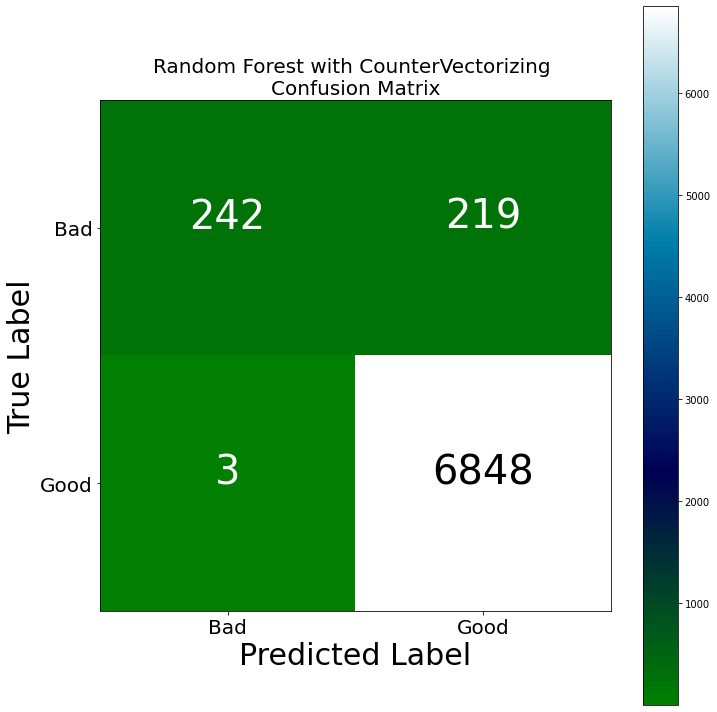

In [ ]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer

In [90]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
nb_cv_sm = modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9591817605976134


In [91]:
filename = 'nb_cv_sm.pkl'
pickle.dump(nb_cv_sm, open(filename, 'wb'))

#### Classification Report

In [92]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       430
           1       0.99      0.97      0.98      3765

    accuracy                           0.96      4195
   macro avg       0.87      0.93      0.89      4195
weighted avg       0.96      0.96      0.96      4195



#### Confusion Matrix

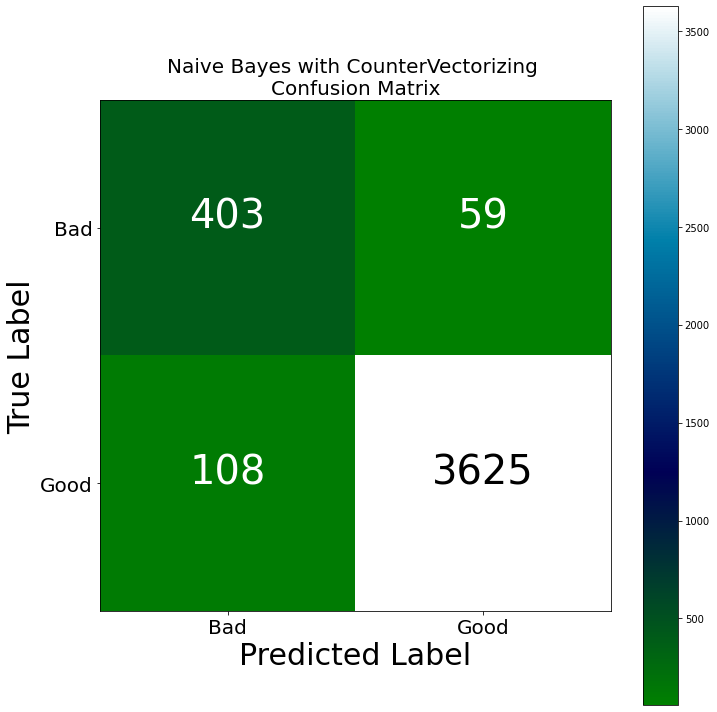

In [ ]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

### 4.1.4 XGBoost with CountVectorizer

In [ ]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
XGboost_cv = modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.9240381644926315


#### Classification Report

In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.58      0.87      0.70       462
           1       0.98      0.92      0.95      3733

    accuracy                           0.92      4195
   macro avg       0.78      0.90      0.83      4195
weighted avg       0.94      0.92      0.92      4195



#### Confusion Matrix

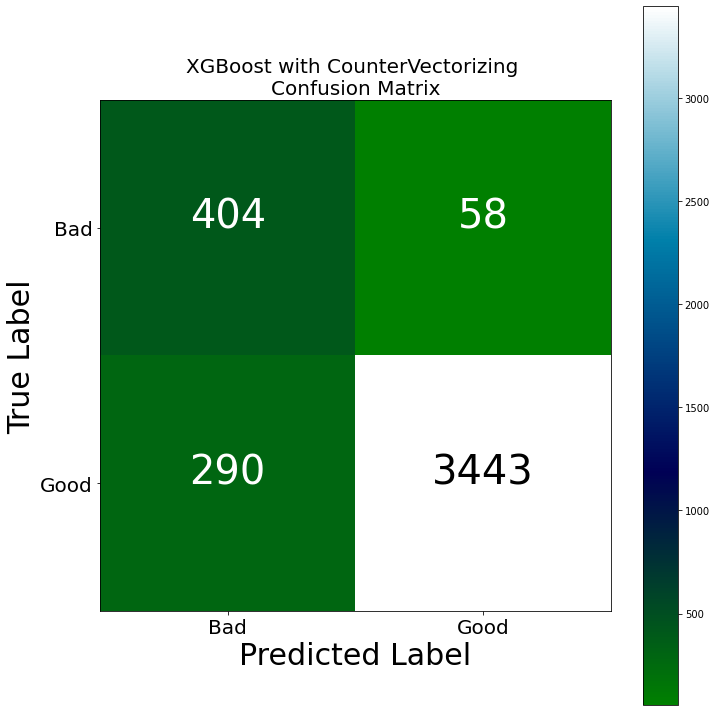

In [ ]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.6 Comparison of Models with CountVectorizer

In [77]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [78]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Function for f1 Score Plotting

In [79]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

### Algorithms Comparison with CountVectorizer

In [ ]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

In [ ]:
df_tv2

precision  ...  support
vectorizer model         accuracy class               ...         
CountVect  LogReg        0.954470 bad       0.753271  ...    462.0
                                  good      0.983880  ...   3733.0
                                  average   0.958483  ...   4195.0
           Random Forest 0.952801 bad       0.768293  ...    462.0
                                  good      0.977316  ...   3733.0
                                  average   0.954296  ...   4195.0
           Naive Bayes   0.960191 bad       0.788650  ...    462.0
                                  good      0.983985  ...   3733.0
                                  average   0.962472  ...   4195.0
           XGBoost       0.917044 bad       0.582133  ...    462.0
                                  good      0.983433  ...   3733.0
                                  average   0.939238  ...   4195.0

[12 rows x 4 columns]

### Average f1 Score - Models with CountVectorizer

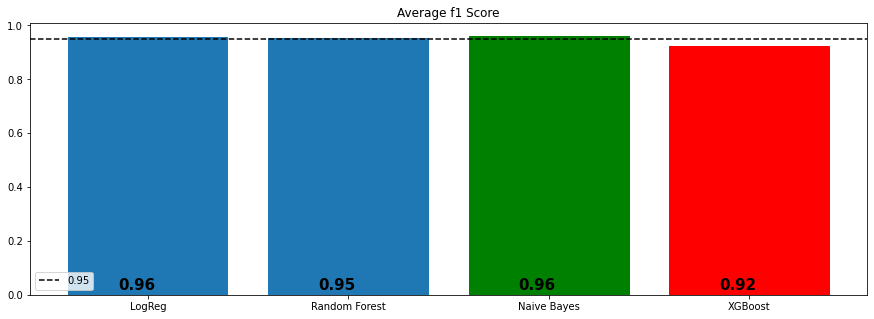

In [ ]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

Naive Bayes Algorithm is Performing best with Count Vectorizer

## 4.2 TF-IDF

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [60]:
import pickle

In [93]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()
pickle.dump(tfidf_vect, open('transform_tfidf.pkl', 'wb'))

In [94]:
tfidf_vect_train_sm , y_train_sm = smote.fit_sample(tfidf_vect_train,y_train)

In [63]:
y_train_sm.shape

(22464,)

In [95]:
def modeling_tfidf(Model, Xtrain = tfidf_vect_train_sm, Xtest = tfidf_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train_sm)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
    return model

### 4.2.1 Logistic Regression with TF-IDF

In [70]:

# Call the modeling function for logistic regression with TF-IDF and print f1 score
Logistic_tfidf = modeling_tfidf(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train_sm, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.9570945288800451


#### Classification Report

In [71]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       427
           1       0.99      0.96      0.97      3768

    accuracy                           0.95      4195
   macro avg       0.85      0.94      0.89      4195
weighted avg       0.96      0.95      0.96      4195



#### Confusion Matrix

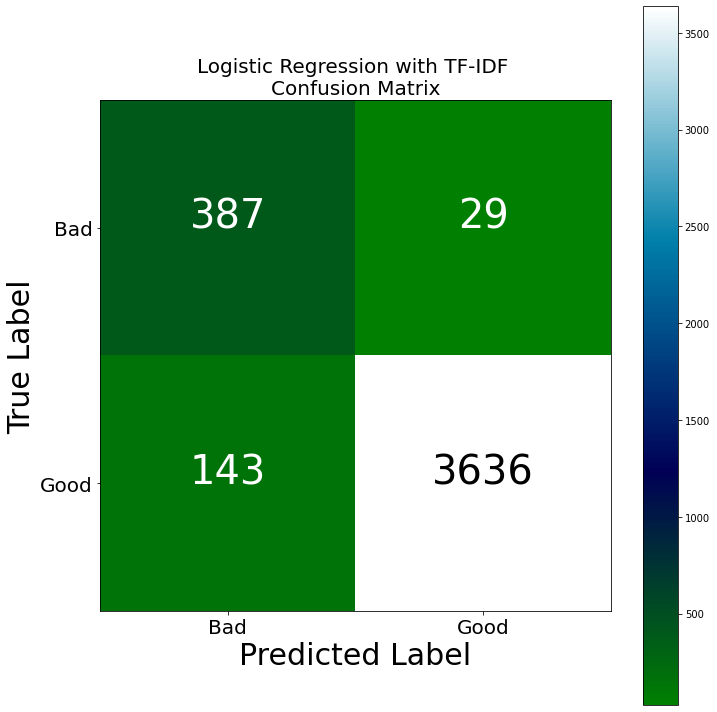

In [38]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [96]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
random_tfidf = modeling_tfidf(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train_sm, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.9636757087713469


#### Classification Report

In [97]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82       430
           1       0.97      0.99      0.98      3765

    accuracy                           0.96      4195
   macro avg       0.93      0.87      0.90      4195
weighted avg       0.96      0.96      0.96      4195



In [99]:
filename = 'rf_tdidf_sm.pkl'
pickle.dump(random_tfidf, open(filename, 'wb'))

#### Confusion Matrix

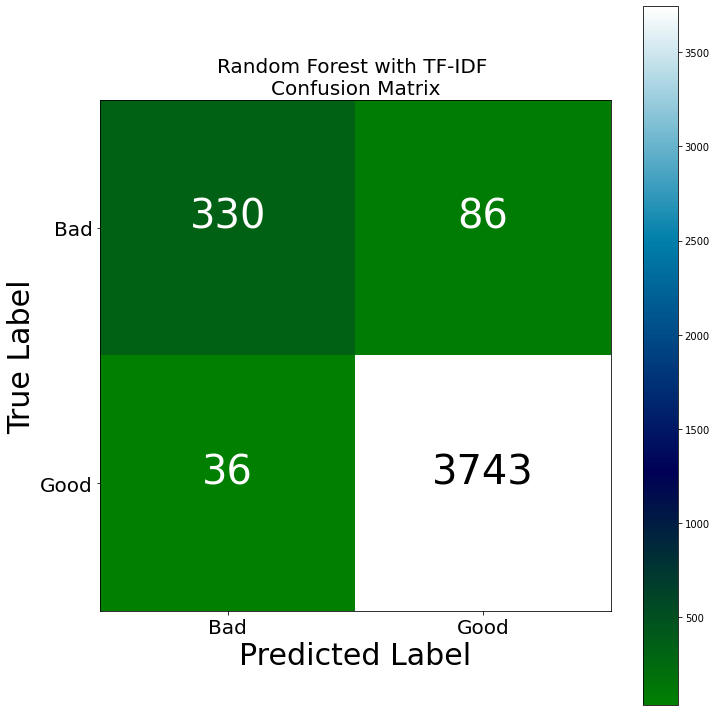

In [41]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [72]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
nb_tfidf_sm = modeling_tfidf(MultinomialNB(), tfidf_vect_train_sm, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.941421659698078


#### Classification Report

In [73]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75       427
           1       0.99      0.94      0.96      3768

    accuracy                           0.94      4195
   macro avg       0.81      0.94      0.86      4195
weighted avg       0.96      0.94      0.94      4195



#### Confusion Matrix

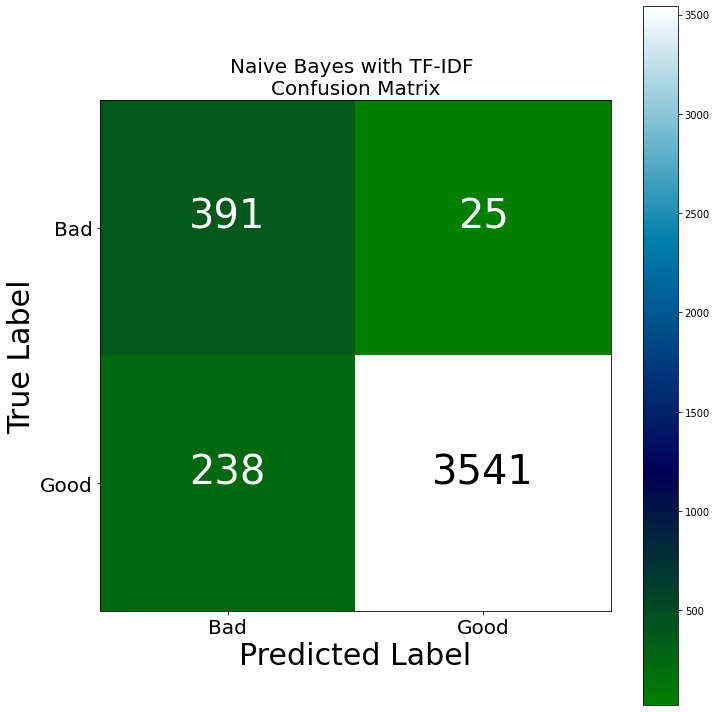

In [45]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [66]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
xg_boost_tfidf = modeling_tfidf(XGBClassifier(), tfidf_vect_train_sm, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.9379023008820442


In [ ]:
filename = 'xg_model.pkl'
pickle.dump(model, open(filename, 'wb'))

#### Classification Report

In [68]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72       427
           1       0.98      0.94      0.96      3768

    accuracy                           0.93      4195
   macro avg       0.80      0.90      0.84      4195
weighted avg       0.95      0.93      0.94      4195



#### Confusion Matrix

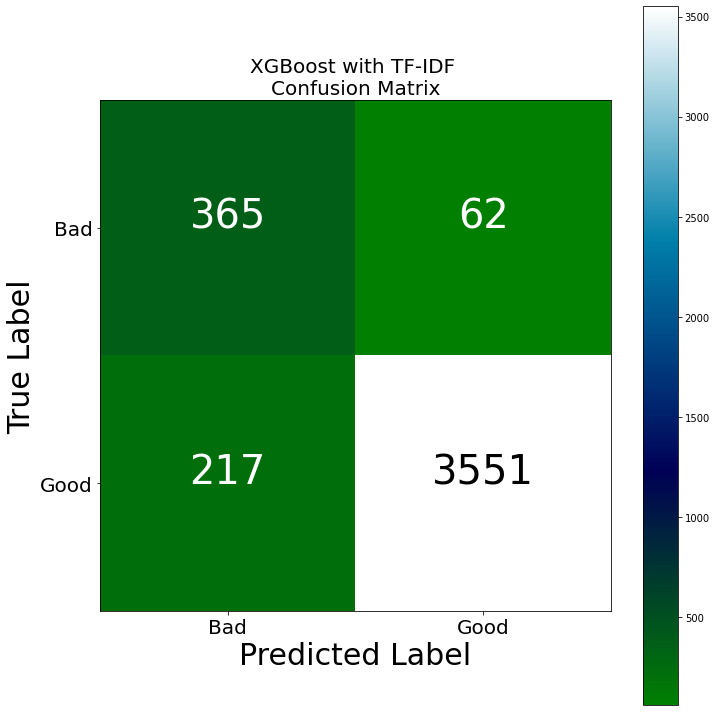

In [69]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.6 Comparision of Models with TF-IDF Vectorizer

In [80]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

#### Comparison Table - TF-IDF Vectorizing

In [81]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision  ...  support
vectorizer model         accuracy class               ...         
CountVect  LogReg        0.954470 bad       0.711470  ...    427.0
                                  good      0.991751  ...   3768.0
                                  average   0.963222  ...   4195.0
           Random Forest 0.967104 bad       0.862155  ...    427.0
                                  good      0.978135  ...   3768.0
                                  average   0.966330  ...   4195.0
           Naive Bayes   0.935876 bad       0.622671  ...    427.0
                                  good      0.992678  ...   3768.0
                                  average   0.955016  ...   4195.0
           XGBoost       0.933492 bad       0.627148  ...    427.0
                                  good      0.982840  ...   3768.0
                                  average   0.946635  ...   4195.0

[12 rows x 4 columns]

#### Average f1 score - Models with TF-IDF Vectorizer

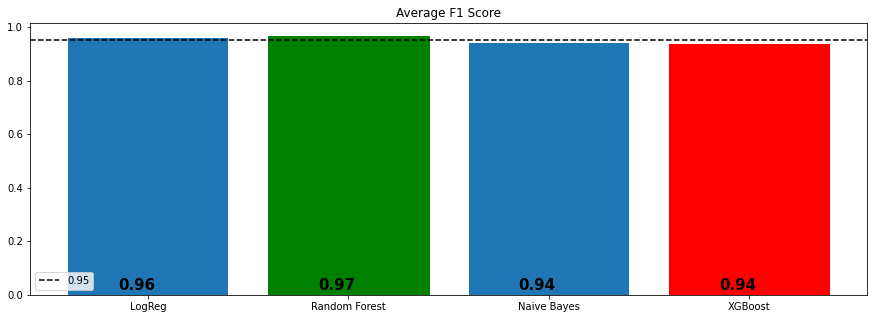

In [82]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

Random Forest is behaving best with TDF-IDF Vectorizer

Conclusion : Naive Bayes with Count Vectorizer and Random Forest with TFIDF is working best. Random Forest (TDIDF) is slightly better than NaiveBayes(Count Vectorizer). Howver we are choosing final Model we are choosing is Naive Bayes with Count Vectorizer as it is very fast and with real time application it gives faster results.

# Recommendation System

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
import gzip

In [ ]:
# Read the file
product_ratings = pd.read_csv('/content/drive/MyDrive/Data/sample30.csv')

In [ ]:
product_ratings.shape

(30000, 15)

Drop unnecessary columns

In [ ]:
product_ratings.drop(['reviews_doRecommend','reviews_didPurchase','categories','reviews_date','manufacturer','categories','brand','reviews_text','reviews_title','reviews_userCity','reviews_userProvince','user_sentiment'], axis=1, inplace=True)

In [ ]:
product_ratings.head()

id  ... reviews_username
0  AV13O1A8GV-KLJ3akUyj  ...           joshua
1  AV14LG0R-jtxr-f38QfS  ...        dorothy w
2  AV14LG0R-jtxr-f38QfS  ...        dorothy w
3  AV16khLE-jtxr-f38VFn  ...          rebecca
4  AV16khLE-jtxr-f38VFn  ...        walker557

[5 rows x 4 columns]

In [ ]:
product_ratings.drop(['id'], axis=1, inplace=True)

In [ ]:
product_ratings.head()

name  reviews_rating reviews_username
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)               5           joshua
1  Lundberg Organic Cinnamon Toast Rice Cakes               5        dorothy w
2  Lundberg Organic Cinnamon Toast Rice Cakes               5        dorothy w
3            K-Y Love Sensuality Pleasure Gel               1          rebecca
4            K-Y Love Sensuality Pleasure Gel               1        walker557

In [ ]:
prod_ratings=product_ratings.rename(columns={'name': 'product_title', 'reviews_username' : 'reviews_username'})

In [ ]:
prod_ratings=prod_ratings.dropna()

In [ ]:
prod_ratings.shape

(29937, 3)

In [ ]:
prod_ratings

product_title  ...  reviews_username
0              Pink Friday: Roman Reloaded Re-Up (w/dvd)  ...            joshua
1             Lundberg Organic Cinnamon Toast Rice Cakes  ...         dorothy w
2             Lundberg Organic Cinnamon Toast Rice Cakes  ...         dorothy w
3                       K-Y Love Sensuality Pleasure Gel  ...           rebecca
4                       K-Y Love Sensuality Pleasure Gel  ...         walker557
...                                                  ...  ...               ...
29995  L'or233al Paris Elvive Extraordinary Clay Reba...  ...        laurasnchz
29996  L'or233al Paris Elvive Extraordinary Clay Reba...  ...     scarlepadilla
29997  L'or233al Paris Elvive Extraordinary Clay Reba...  ...        liviasuexo
29998  L'or233al Paris Elvive Extraordinary Clay Reba...  ...          ktreed95
29999  L'or233al Paris Elvive Extraordinary Clay Reba...  ...         kcoopxoxo

[29937 rows x 3 columns]

In [ ]:
len(prod_ratings['reviews_username'].unique())

24914

In [ ]:
counts1=prod_ratings['reviews_username'].value_counts() 
counts=prod_ratings['product_title'].value_counts()

counts1

mike                 41
byamazon customer    41
chris                32
lisa                 16
tony                 15
                     ..
tracyw                1
bklaurid99            1
kbruno                1
exymus                1
mammak                1
Name: reviews_username, Length: 24914, dtype: int64

In [ ]:
counts

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8525
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
Wallmount Server Cabinet (450mm, 9 RU)                                               1
Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct                                       1
Scotty Mini Double Ended Extender                                                    1
Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler               1
Walkers Stem Ginger Shortbread                                                       1
Name: product_title, Length: 271, dtype: in

In [ ]:
df1=prod_ratings[prod_ratings['reviews_username'].isin(counts1[counts1 >=1].index)]
df1.shape

(29937, 3)

In [ ]:
df1=df1[df1['product_title'].isin(counts[counts >=10].index)]
df1.shape

(29361, 3)

In [ ]:
df1.head()

product_title  reviews_rating reviews_username
3  K-Y Love Sensuality Pleasure Gel               1          rebecca
4  K-Y Love Sensuality Pleasure Gel               1        walker557
5  K-Y Love Sensuality Pleasure Gel               1         samantha
6  K-Y Love Sensuality Pleasure Gel               1          raeanne
7  K-Y Love Sensuality Pleasure Gel               1           kimmie

In [ ]:
ratings_sum = pd.DataFrame(df1.groupby(['product_title'])['reviews_rating'].sum()).rename(columns = {'reviews_rating': 'ratings_sum'})
top10 = ratings_sum.sort_values('ratings_sum', ascending = False).head(10)
top10

ratings_sum
product_title                                                  
Clorox Disinfecting Wipes Value Pack Scented 15...        41095
Godzilla 3d Includes Digital Copy Ultraviolet 3...        14466
Clorox Disinfecting Bathroom Cleaner                       9869
Planes: Fire Rescue (2 Discs) (includes Digital...         5346
L'or233al Paris Elvive Extraordinary Clay Rebal...         4776
Burt's Bees Lip Shimmer, Raisin                            4060
The Resident Evil Collection 5 Discs (blu-Ray)             3950
Mike Dave Need Wedding Dates (dvd + Digital)               3258
Red (special Edition) (dvdvideo)                           3126
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Dig...         3000

In [ ]:
top10_popular=top10.merge(df1,left_index = True, right_on = 'product_title').drop_duplicates(
    ['product_title'])[['product_title','ratings_sum']]

In [ ]:
print ('Top 10 Popular Products by sum user ratings\n')
top10_popular

Top 10 Popular Products by sum user ratings



product_title  ratings_sum
6479   Clorox Disinfecting Wipes Value Pack Scented 1...        41095
22884  Godzilla 3d Includes Digital Copy Ultraviolet ...        14466
18569               Clorox Disinfecting Bathroom Cleaner         9869
27222  Planes: Fire Rescue (2 Discs) (includes Digita...         5346
28814  L'or233al Paris Elvive Extraordinary Clay Reba...         4776
15739                    Burt's Bees Lip Shimmer, Raisin         4060
4531      The Resident Evil Collection 5 Discs (blu-Ray)         3950
1796        Mike Dave Need Wedding Dates (dvd + Digital)         3258
5591                    Red (special Edition) (dvdvideo)         3126
2583   My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...         3000

In [ ]:
df2 = df1.drop_duplicates(subset=['reviews_username','product_title',],keep='first')
df2.shape

(27021, 3)

In [ ]:
df2.head()

product_title  reviews_rating reviews_username
3  K-Y Love Sensuality Pleasure Gel               1          rebecca
4  K-Y Love Sensuality Pleasure Gel               1        walker557
5  K-Y Love Sensuality Pleasure Gel               1         samantha
6  K-Y Love Sensuality Pleasure Gel               1          raeanne
7  K-Y Love Sensuality Pleasure Gel               1           kimmie

In [ ]:
df3 = df2.reset_index()

In [ ]:
df3.head()

index                     product_title  reviews_rating reviews_username
0      3  K-Y Love Sensuality Pleasure Gel               1          rebecca
1      4  K-Y Love Sensuality Pleasure Gel               1        walker557
2      5  K-Y Love Sensuality Pleasure Gel               1         samantha
3      6  K-Y Love Sensuality Pleasure Gel               1          raeanne
4      7  K-Y Love Sensuality Pleasure Gel               1           kimmie

Ratings Analysis in Final Dataset

In [ ]:
ratingsd=df3.pivot(index='reviews_username',columns= 'product_title',values='reviews_rating').fillna(0)
ratingsd.head()

product_title     100:Complete First Season (blu-Ray)  ...  Yes To Grapefruit Rejuvenating Body Wash
reviews_username                                       ...                                          
00dog3                                            0.0  ...                                       0.0
00sab00                                           0.0  ...                                       0.0
01impala                                          0.0  ...                                       0.0
02dakota                                          0.0  ...                                       0.0
02deuce                                           0.0  ...                                       0.0

[5 rows x 120 columns]

In [ ]:
ratingsd.to_csv('/content/drive/MyDrive/Data/recommend_sample30.csv', sep=',', encoding='utf-8', index = False)

In [ ]:
ratingsd.shape

(24471, 120)

### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
traind, testd = train_test_split(ratingsd, test_size=0.30,random_state=42)

In [ ]:
train = traind.to_numpy()
test = testd.to_numpy()

In [ ]:
sparsity = float(len(train.nonzero()[0]))
sparsity /= (train.shape[0] * train.shape[1])
sparsity *= 100
print ('Sparsity: {:5.2f}%'.format(sparsity))

Sparsity:  0.92%


## Item Based Collaborative filtering

In [ ]:
def item_similarity(ratings, epsilon=1e-9):
    # epsilon -> for handling dived-by-zero errors
    sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [ ]:
item_sim = item_similarity(train)

In [ ]:
def predict_item(ratings, similarity):
    return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [ ]:
item_prediction = predict_item(train, item_sim)

In [ ]:
item_prediction[:4, :4]

array([[4.26523907e-02, 2.50935586e-02, 8.36518325e-02, 2.23153139e-12],
       [8.16228113e-02, 4.04392549e-02, 1.34709950e-12, 1.28296051e-12],
       [1.41246912e-02, 1.10919817e-02, 1.93983584e-02, 7.38990039e-13],
       [1.53073164e-12, 2.10362000e-12, 5.88630968e-12, 5.60604682e-12]])

In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

Item-based CF MSE: 18.531532960245258


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
r_mat_tr=svd.fit_transform(traind) 
print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())

#pm=pd.DataFrame(cosine_similarity(r_mat_tr))
#pm.head()
ctrain = cosine_similarity(r_mat_tr)


[0.24714421 0.10534223 0.08261033 0.04616045 0.03690164 0.03509155
 0.02871742 0.02773542 0.02836484 0.0273276  0.02534966 0.01652573
 0.01452592 0.01283761 0.01199568 0.0116394  0.01105534 0.01010821
 0.00893327 0.00868155 0.00834215 0.00818465 0.00778093 0.00757426
 0.00734144 0.00715979 0.0068945  0.00628589 0.00595316 0.00543232
 0.00507959 0.00480342 0.0046181  0.00429109 0.00424766 0.00413372
 0.00403102 0.00392998 0.00390238 0.0031973  0.00307816 0.00296851
 0.00285803 0.00275978 0.0027505  0.00267159 0.00247813 0.00233329
 0.00215727 0.00207556]
0.9363622188452048


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
r_mat_tr=svd.fit_transform(testd) 
print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())

#pmtt=pd.DataFrame(cosine_similarity(r_mat_tr))
#print (pmtt[:2])
#pmtt.head()
ctest = cosine_similarity(r_mat_tr)

[0.24745803 0.10885827 0.0828781  0.04676964 0.03913565 0.03578314
 0.03071465 0.02846044 0.0280707  0.02445266 0.0246685  0.01882939
 0.01390314 0.0113337  0.01136119 0.01077885 0.00993185 0.00983193
 0.00945271 0.00911502 0.00868799 0.00843082 0.00829357 0.00769911
 0.0072009  0.00625237 0.00609792 0.00601781 0.00596704 0.00590926
 0.00540297 0.00508188 0.00499507 0.00422224 0.00422302 0.00389555
 0.00375948 0.00369099 0.00356072 0.00309747 0.00296883 0.00283504
 0.00275529 0.00261127 0.00261031 0.00249206 0.00234938 0.00221202
 0.00197344 0.00195287]
0.9390342850883384


In [ ]:
print (' CF MSE: ' + str(get_mse(ctrain, ctest)))

 CF MSE: 0.20360890966448228


## User Based Collaborative Filtering

In [ ]:
df3 = df3.sort_values(by='reviews_rating')
df3 = df3.reset_index(drop=True)
count_users = df3.groupby("reviews_username", as_index=False).count()

In [ ]:
count = df3.groupby("product_title", as_index=False).mean()

In [ ]:
items_df = count[['product_title']]
items_df.head()
print(len(items_df))

120


In [ ]:
users_df = count_users[['reviews_username']]
users_df.head()
print(len(users_df))


24471


In [ ]:
users_list = users_df.values
len(users_list)

24471

In [ ]:
df_clean_matrix = df3.pivot(index='product_title', columns='reviews_username', values='reviews_rating').fillna(0)
df_clean_matrix = df_clean_matrix.T
R = (df_clean_matrix).to_numpy()
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
R_demeaned

array([[-0.03333333, -0.03333333, -0.03333333, ..., -0.03333333,
        -0.03333333, -0.03333333],
       [-0.03333333, -0.03333333, -0.03333333, ..., -0.03333333,
        -0.03333333, -0.03333333],
       [-0.025     , -0.025     , -0.025     , ..., -0.025     ,
        -0.025     , -0.025     ],
       ...,
       [-0.04166667, -0.04166667, -0.04166667, ..., -0.04166667,
        -0.04166667, -0.04166667],
       [-0.04166667, -0.04166667, -0.04166667, ..., -0.04166667,
        -0.04166667, -0.04166667],
       [-0.03333333, -0.03333333, -0.03333333, ..., -0.03333333,
        -0.03333333, -0.03333333]])

As this is a sparse matrix we will use SVD. 

### Singular Value Decomposition

In [ ]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned)

In [ ]:
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_clean_matrix.columns)
preds_df['reviews_username'] = users_df
preds_df.set_index('reviews_username', inplace=True)
preds_df.head()

product_title     100:Complete First Season (blu-Ray)  ...  Yes To Grapefruit Rejuvenating Body Wash
reviews_username                                       ...                                          
00dog3                                       0.034430  ...                                  0.035183
00sab00                                      0.033302  ...                                  0.029153
01impala                                     0.009884  ...                                 -0.001995
02dakota                                     0.016473  ...                                 -0.003324
02deuce                                      0.013179  ...                                 -0.002659

[5 rows x 120 columns]

In [ ]:
preds_df.shape

(24471, 120)

In [ ]:
def recommend_it(predictions_df, itm_df, original_ratings_df, num_recommendations=10,ruserId='joshua'):
    
    # Get and sort the user's predictions
    sorted_user_predictions = predictions_df.loc[ruserId].sort_values(ascending=False)
    
    # Get the user's data and merge in the item information.
    user_data = original_ratings_df[original_ratings_df.reviews_username == ruserId]
    user_full = (user_data.merge(itm_df, how = 'left', left_on = 'product_title', right_on = 'product_title').
                     sort_values(['reviews_rating'], ascending=False)
                 )

    print ('User {0} has already purchased {1} items.'.format(ruserId, user_full.shape[0]))
    print ('Recommending the highest {0} predicted  items not already purchased.'.format(num_recommendations))
    
    # Recommend the highest predicted rating items that the user hasn't bought yet.
    recommendations = (itm_df[~itm_df['product_title'].isin(user_full['product_title'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'product_title',
               right_on = 'product_title').
         rename(columns = {ruserId: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )
    topk=recommendations.merge(original_ratings_df, right_on = 'product_title',left_on='product_title').drop_duplicates(
    ['product_title'])[['product_title']]

    return topk

In [ ]:
recommend_it(preds_df, items_df, df3, 5)

User joshua has already purchased 3 items.
Recommending the highest 5 predicted  items not already purchased.


product_title
0        The Resident Evil Collection 5 Discs (blu-Ray)
821        Mike Dave Need Wedding Dates (dvd + Digital)
1537  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
2187                             Hormel Chili, No Beans
2381                  Tostitos Bite Size Tortilla Chips

In [ ]:
#recommend for any user
recommend_it(preds_df, items_df, df3, 5,'kleeo')


User kleeo has already purchased 1 items.
Recommending the highest 5 predicted  items not already purchased.


product_title
399   L'or233al Paris Elvive Extraordinary Clay Reba...
1012                         Lundberg Wehani Rice, 25lb
1601  Avery174 Ready Index Contemporary Table Of Con...
615   Storkcraft Tuscany Glider and Ottoman, Beige C...
1     Aveeno Baby Continuous Protection Lotion Sunsc...

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.